In [ ]:
import warnings

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

#Imports

import matplotlib.pyplot as plt
from PIL import Image as im
from skimage.color import rgb2gray
import cv2 as cv

from google.colab import files
import os
import math
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K


Mounted at /content/drive


In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
import os
from skimage import io
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage import measure as sk
import glob
import datetime
import multiprocessing

from skimage import data
from skimage.color import rgb2gray

In [ ]:
#Defining Parameters for Image Conversion
scale = 9#4.5 #Scales the radii of the diffraction profiles (large scale increases space between 'rings')
resolution = 128#256#150#150#126*2 #Determines image resolution
noise_level = 0.2

size_img = 128

radius_scale = 1

In [ ]:
#Open and processes data in all files in a given directory
#Returns one list of radii and another of intensities


def retrieve_data(directory="/content/drive/MyDrive/AI for UED/Bismuth Profiles",uiso_lower_bound = 0.01, uiso_increment=0.1,uiso_upper_bound=1,intensity_scale=1):

  #Creating an array of file names for all Bi files
  files_to_open = []
  uiso_vals_in_range = np.arange(uiso_lower_bound,uiso_upper_bound,uiso_increment)
  uiso_vals_in_range = [round(elem, 5) for elem in uiso_vals_in_range ]

  """
  for val in range(0,11,1):
    #print(val/10)
    file_name = directory + str(val/10) + ".txt"
    files_to_open.append(file_name)
  """
  #Opening files and processing data into lists of radii and intensities

  radii = []
  intensities = []
  uiso_labels = []
  print("----RETRIEVING DATA----")
  for subdirectories, directories, files in os.walk(directory):
    index = 0
    denom = len(uiso_vals_in_range)
    for file_name in files:
      #print(subdirectories + os.path.sep + file_name)
      if '(1)' not in file_name.split("reciprocal_")[1].split(".txt")[0]:
        uiso_val = float(file_name.split("reciprocal_")[1].split(".txt")[0])

        if uiso_val in uiso_vals_in_range:
          file = open(subdirectories + os.path.sep + file_name, "r")
          array_vals = []
          #percent_val = round(100*uiso_vals_in_range.index(uiso_val)/len(uiso_vals_in_range),0)
          percent_val = round(100*index/denom,0)
          index+=1
          if percent_val%20 == 0:
            print(str(percent_val)+"%")
          for line in file:
            data_point = line.split() #X and Y values are separated by a space
            array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),intensity_scale*float(data_point[1])]) #converts angles into radii
          radius,intensity = zip(*array_vals) #Unzipping array of [x_values,y_values] into list of x_values and y_values
          radii.append(radius)
          intensities.append(intensity)
          uiso_labels.append(uiso_val)
  print("----DONE----")
  for i in range(0,len(radii)):
    plt.plot(radii[i],intensities[i])
  plt.show()
  plt.clf()
  print("Have {} datapoints for training".format(len(radii)))


  return uiso_labels, radii, intensities

def add_multiplicative_noise(input_img):
  noise = 1+(noise_level*np.random.randn(resolution,resolution))
  noisy_img = input_img*noise
  return noisy_img

#uiso_labels, radii, intensities = retrieve_data(uiso_lower_bound = 0.0138, uiso_increment=0.0001,uiso_upper_bound=0.05)

In [ ]:
#Converts Radii-Intensity data into Diffraction Patterns
#Returns 2D array in which each element is: [diffraction pattern, label]

def generate_diffraction_patterns(uiso_labels,radii,intensities,one_hot_vecs,invert=False,num_augmentations=2,num_img_to_generate=7,deblurring=False,transform_image=True,sub=False,get_sub=False):

  #This code generates a two-part circular mask
  #This mask obscures all points greater than a distance of 'curr_rad' and less than a distance of 'prev_rad'
  #This creates a circle, the radius of which depends on the resolution of the angle data
  #This mask is applied to a white image in order to generate a fully white circle
  #source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
  #Added an invert option because it looks cool

  images = [] #images will be a list of [diffraction patterns, labels]

  #Setting up a (resolution,resolution) sized array for the mask
  #Ogrid is used to setup a row and column vector of values ranging from 0 to resolution

  Y,X = np.ogrid[:resolution,:resolution]
  centre_val = resolution/2

  #The values stored in each vector are squared and the vectors are added (using broadcasting)
  #The value at each point of the resulting array is the 'distance' between that point and the centre
  dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)

  #white image used to generate white circles
  #array_ones = np.ones((resolution,resolution))

  datagen = ImageDataGenerator(
    #zoom_range = 0.1,
    #rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    )
  print("----GENERATING DIFFRACTION PATTERNS----")
  for i in range(0,len(radii)): #iterates through all diffraction profiles
    percent_val = round(100*i/len(radii),0)
    if percent_val%20 == 0:
      print(str(percent_val)+"%")
    #creates a 'base image' for the background of the image
    """
    if invert:
      base_img = np.ones((resolution,resolution))*255
    else:
      base_img = np.zeros((resolution,resolution))
    """

    base_img = np.zeros((resolution,resolution))
    uiso_label = uiso_labels[i]
    radius = radii[i]
    intensity = intensities[i]



    #Scaling the radii of each diffraction pattern
    #This ensures that the smallest radii rings (the brightest rings) have a radius equal to 8.5% of the image's width/height
    min_rad = radius[0]
    #radius_adjustment_value = radius_scale*(resolution/2)*0.17/min_rad
    radius_adjustment_value = radius_scale*(resolution/2)*0.1735/min_rad

    prev_rad = radius[0]*radius_adjustment_value
    max_intensity = max(intensity)
    for j in range(0,len(radius)):
      curr_rad = radius[j]*radius_adjustment_value
      if curr_rad > 45:
        break

      #Defining the two-part mask
      mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)
      white_image = np.ones((resolution,resolution)) #np.copy(array_ones)

      #applies mask to white image
      white_image[~mask]=0

      #normalizing by setting uiso_0 images equal to OFF images in lab data
      base_img += white_image*intensity[j]#*8000/max(intensities[0])
      prev_rad = curr_rad

    base_img = base_img*8000/90247000
    max_image_brightness = max(np.ndarray.flatten(base_img))

    # Setting up stopper + bright spot
    X_centered = X - resolution/2
    Y_centered = Y - resolution/2

    #making x/y square arrays
    lin_combination_image = Y_centered+X_centered

    X_square = lin_combination_image-Y_centered
    Y_square = X_centered-lin_combination_image

    #determining distance of each point in array from centre (this will be used in bright spot's the mask)
    dist_from_center = (np.sqrt((X-centre_val)**2+(Y-centre_val)**2))

    max_dist = max(np.ndarray.flatten(dist_from_center))

    #normalizes distance values
    normalized_bright_spot = (max_dist-dist_from_center)/max_dist

    #defines mask for the bright spot in the middle (with a dark spot because of the stopper)
    bright_spot_mask = (normalized_bright_spot>0.955) & (normalized_bright_spot<0.97)

    #applies mask
    normalized_bright_spot[~bright_spot_mask] = 0

    #Brightens spot based on rest of image
    normalized_bright_spot *= max_image_brightness

    #Defining mask for stopper's wire

    lin_eq_square =Y_square + 4*X_square #Defines the stopper wire's equation as b = Y + 4*X , with b ranging from +-0.04*resolution in order to give the wire some thickness
    quadrant_mask = (X_square>0) #Only want the stopper's wire in the 4th quadrant, so we limit X > 0
    wire_mask = (lin_eq_square<resolution*0.04) & (lin_eq_square>-resolution*0.04)



    #applies both masks to white image to create image of stopper

    #Subtracts image of stopper from the base image, and adds the bright spot in the middle

    #base_img = np.clip(base_img - white_image + normalized_bright_spot,0,max_image_brightness)



    mean = resolution/2
    div_param = 1
    mult_param = 82500
    exp_param = 2
    #stdev = 0.425*resolution
    stdev = 0.35*resolution
    #gaussian_base = np.clip(mult_param*(1/(((X-mean)/div_param)**(2)+((Y-mean)/div_param)**(2)))**(1/exp_param),0,999999999)
    #gaussian_base = 4000*np.exp((-(X-mean)**(2)-(Y-mean)**2)/(stdev)**2)
    gaussian_base = 15000*np.exp((-(X-mean)**(2)-(Y-mean)**2)/(stdev)**2)
    dist_from_center = np.sqrt((X-resolution/2)**2+(Y-resolution/2)**2)
    mask = (dist_from_center > 13)
    gaussian_base[~mask]=0

    #new mask


    #mask = (dist_from_center < 40)
    #gaussian_base[~mask]=0


    base_img_unadjusted = base_img

    base_img = base_img + gaussian_base

    max_image_brightness = max(np.ndarray.flatten(base_img))
    white_image = max_image_brightness*np.ones((resolution,resolution))
    white_image[~wire_mask]=0
    white_image[~quadrant_mask]=0
    base_img = np.clip(base_img - white_image ,0,max_image_brightness)
    base_img_unadjusted = np.clip(base_img_unadjusted - white_image ,0,max_image_brightness)
    if get_sub:
      return [base_img_unadjusted,uiso_label]
    if sub==True:
      base_img_unadjusted = base_img_unadjusted - sub_img_X
    #add multiplicative/additive noise (turned off for now)
    #base_img_noisy = add_multiplicative_noise(base_img)

    #Blurring and randomly translating images to generate more datapoints
    #We'll repeat the augmentation code multiple times, each time with a different blur
    #"""

    #for augmentation in range(0,2):
    #print(uiso_label)

    max_translation = int(0.1*resolution)
    if (not transform_image):
      max_translation = 0
    for augmentation in range(0,num_augmentations):

      #for q in range(0,3):
      for q in range(0,num_img_to_generate):
        M = np.float32([
        [1, 0, random.randint(-max_translation,max_translation)],
        [0, 1, random.randint(-max_translation,max_translation)]
        ])
        new_image = cv.warpAffine(base_img, M, (resolution,resolution))
        new_image_unadjusted = cv.warpAffine(base_img_unadjusted, M, (resolution,resolution))

        blurry_img_expanded=np.expand_dims(np.expand_dims(new_image,-1),0)
        blurry_img_expanded_unadjusted=np.expand_dims(np.expand_dims(new_image_unadjusted,-1),0)


        num_images_generated = 0

        if deblurring:
          reshaped_augmented_image = np.reshape(blurry_img_expanded,(resolution,resolution))
          reshaped_augmented_image_blurry = cv.GaussianBlur(reshaped_augmented_image,(5,5),0.3+random.uniform(-0.3, 0.3))
          reshaped_augmented_image_unadjusted = np.reshape(blurry_img_expanded_unadjusted,(resolution,resolution))


          #normalizing by max
          reshaped_augmented_image_unadjusted_normalized = reshaped_augmented_image_unadjusted/np.max(reshaped_augmented_image_unadjusted)
          reshaped_augmented_image_blurry_normalized = reshaped_augmented_image_blurry/np.max(reshaped_augmented_image_blurry)


          if invert:
                max_blurry_image_brightness = max(np.ndarray.flatten(reshaped_augmented_image_blurry))
                max_blurry_image_brightness_unadjusted = max(np.ndarray.flatten(reshaped_augmented_image_unadjusted))
                inverted_image = max_blurry_image_brightness - reshaped_augmented_image_blurry
                inverted_image_unadjusted = max_blurry_image_brightness_unadjusted - reshaped_augmented_image_blurry_unadjusted

                images.append(([inverted_image,inverted_image],uiso_label))#round(float(i/(len(radii)-1)),2)])
          else:
                images.append(([np.expand_dims(reshaped_augmented_image_unadjusted_normalized,-1),
                                 np.expand_dims(reshaped_augmented_image_blurry_normalized,-1)],uiso_label))#round(float(i/(len(radii)-1)),2)])

                """
                if np.max(reshaped_augmented_image_unadjusted) != 0:
                  images.append(([np.expand_dims(2*(reshaped_augmented_image_unadjusted/np.max(reshaped_augmented_image_unadjusted)-0.5),-1),
                                  np.expand_dims(2*(reshaped_augmented_image_blurry/np.max(reshaped_augmented_image_blurry)-0.5),-1)],uiso_label))#round(float(i/(len(radii)-1)),2)])

                max_val_unadj = max(np.max(reshaped_augmented_image_unadjusted),-np.min(reshaped_augmented_image_unadjusted))
                max_val_blurry = max(np.max(reshaped_augmented_image_blurry),-np.min(reshaped_augmented_image_blurry))
                if not (max_val_unadj == 0 or max_val_blurry == 0):
                  #print(uiso_label)
                  #h+=1
                  for row_idx in range(size_img):
                    for col_idx in range(size_img):
                      reshaped_augmented_image_unadjusted[row_idx,col_idx] = reshaped_augmented_image_unadjusted[row_idx,col_idx]/max_val_unadj
                      reshaped_augmented_image_blurry[row_idx,col_idx] = reshaped_augmented_image_blurry[row_idx,col_idx]/max_val_blurry


                  images.append(([np.expand_dims(reshaped_augmented_image_unadjusted,-1),
                                  np.expand_dims(reshaped_augmented_image_blurry,-1)],uiso_label))#round(float(i/(len(radii)-1)),2)])
                  #images.append(([reshaped_augmented_image_unadjusted/12000,reshaped_augmented_image_blurry/12000],uiso_label))#round(float(i/(len(radii)-1)),2)])
                """

        else:
          for augmented_image in datagen.flow(blurry_img_expanded):

            if num_images_generated < num_img_to_generate:
              num_images_generated+=1
              reshaped_augmented_image = np.reshape(augmented_image,(resolution,resolution))

              reshaped_augmented_image_blurry = cv.GaussianBlur(reshaped_augmented_image,(5,5),0.3+random.uniform(-0.3, 0.3))
              reshaped_augmented_image_unadjusted = np.reshape(blurry_img_expanded_unadjusted,(resolution,resolution))


              if invert:
                max_blurry_image_brightness = max(np.ndarray.flatten(reshaped_augmented_image_blurry))
                inverted_image = max_blurry_image_brightness - reshaped_augmented_image_blurry

                images.append((np.expand_dims(inverted_image_unadjusted,-1),uiso_label))#round(float(i/(len(radii)-1)),2)])
              else:
                  #images.append((np.expand_dims(2*(reshaped_augmented_image/np.max(reshaped_augmented_image)-0.5),-1),uiso_label))#round(float(i/(len(radii)-1)),2)])
                  images.append((reshaped_augmented_image_unadjusted,uiso_label))#round(float(i/(len(radii)-1)),2)])

            else:
              break
    #"""
  #Shuffles dataset
  #random.shuffle(images)
  print("----DONE----")
  #print("CURRENTLY NOT NORMALIZING IMAGES")
  return images

----RETRIEVING DATA----
0.0%
----DONE----


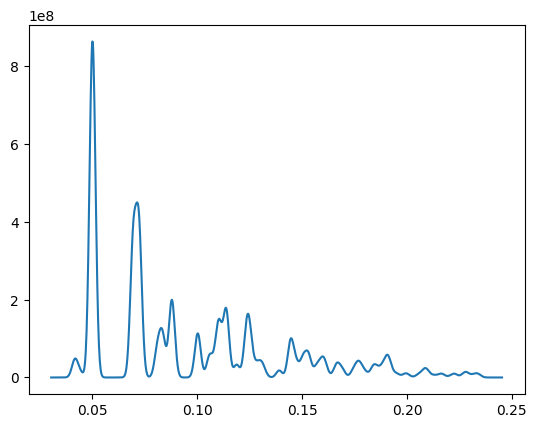

Have 1 datapoints for training
----GENERATING DIFFRACTION PATTERNS----
0.0%
----DONE----
(1, 128, 128, 1)


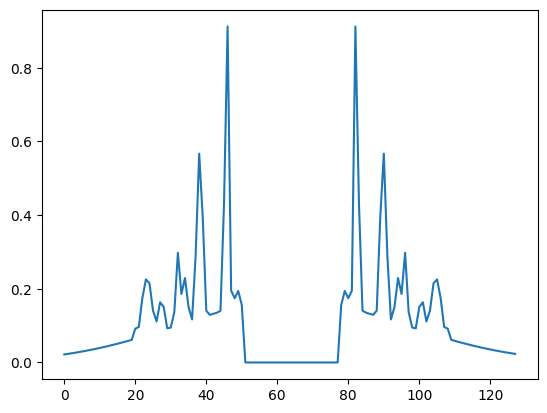

In [ ]:
uiso_labels, radii, intensities = retrieve_data(uiso_lower_bound = 0.0138
                                                , uiso_increment= 0.001#<- just for placeholder #0.0002#uiso_increment=0.0005
                                                ,uiso_upper_bound=0.014#uiso_upper_bound=0.1259#0.05
                                                ,intensity_scale=10)


#uiso_rad_list = zip(uiso_labels,radii)

#print(uiso_rad_list[0])

#images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_img_to_generate=2,deblurring=True)
images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_augmentations=1,num_img_to_generate=1,deblurring=True,transform_image=False,sub=False)

#images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_augmentations=1,num_img_to_generate=1,deblurring=False,tansform_image=False,sub=False,get_sub=False)

#print(np.shape(images_uiso))
#images.sort(key=lambda a: a[0])

#sub_img_X,uiso_labels = images_uiso

images,uiso_labels = zip(*images_uiso)

X,Y_off = zip(*images)
print(np.shape(X))
plt.plot(Y_off[0][64,0:,:])
plt.show()
#print(np.array

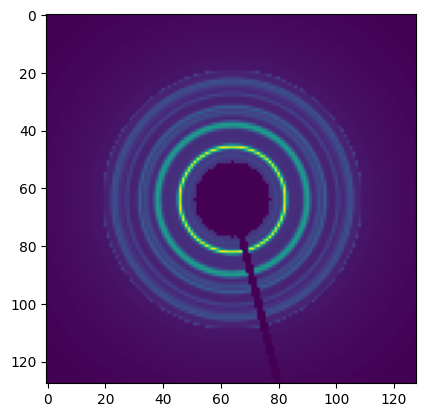

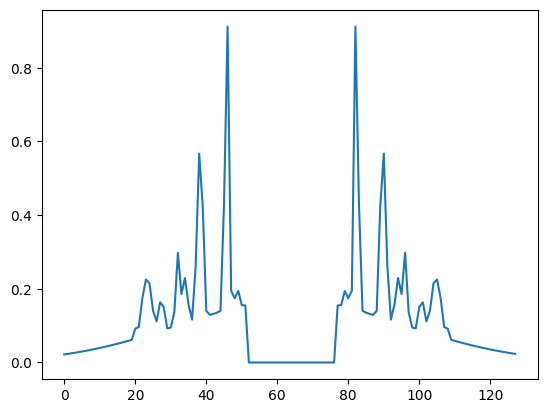

In [ ]:
plt.imshow(Y_off[0][:,:,0])
plt.show()
plt.plot(Y_off[0][65,:,0])
plt.show()

----RETRIEVING DATA----
0.0%
20.0%
20.0%
40.0%
40.0%
60.0%
60.0%
80.0%
80.0%
----DONE----


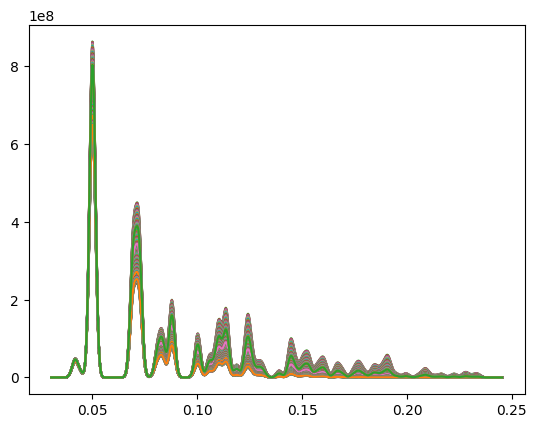

Have 173 datapoints for training


<Figure size 640x480 with 0 Axes>

In [ ]:
uiso_labels, radii, intensities = retrieve_data(uiso_lower_bound = 0.0138
                                                , uiso_increment= 0.0005#0.0005#<- just for placeholder #0.0002#uiso_increment=0.0005
                                                ,uiso_upper_bound=0.1#0.5#uiso_upper_bound=0.1259#0.05
                                                ,intensity_scale=10)

In [ ]:
#uiso_rad_list = zip(uiso_labels,radii)

#print(uiso_rad_list[0])

images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_img_to_generate=6,deblurring=True,sub=False,transform_image=False)
#images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_augmentations=1,num_img_to_generate=1,deblurring=True,transform_image=False)

#print(np.shape(images_uiso))
images_uiso.sort(key=lambda a: a[1])

images,uiso_labels = zip(*images_uiso)

#Y,X = zip(*images)
X,Y = zip(*images)

print(len(X))


----GENERATING DIFFRACTION PATTERNS----
0.0%
20.0%
20.0%
40.0%
40.0%
60.0%
60.0%
80.0%
80.0%
----DONE----
2076


In [ ]:
#print(max(uiso_labels))

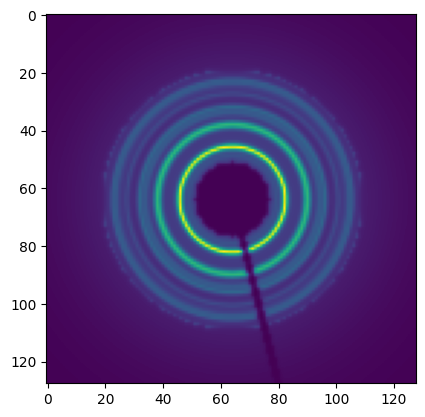

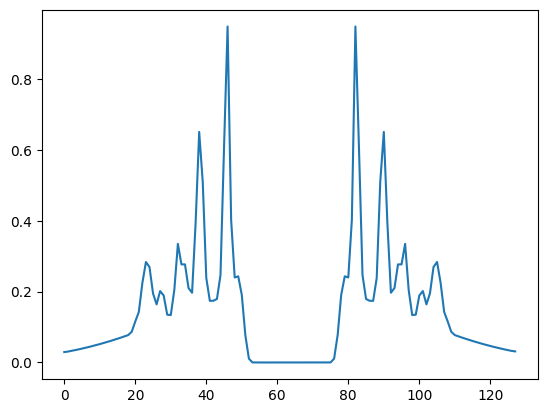

0.0138


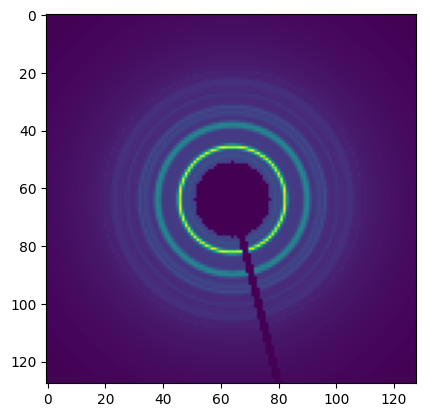

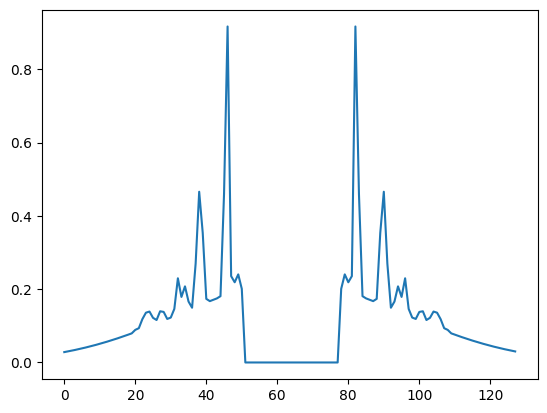

0.0998


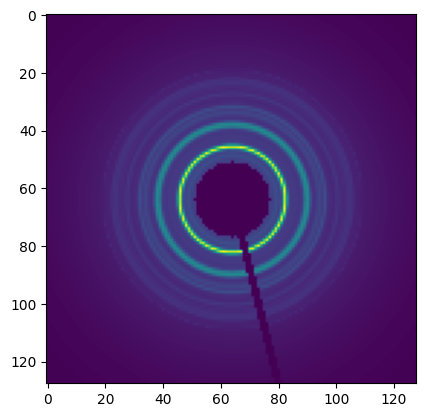

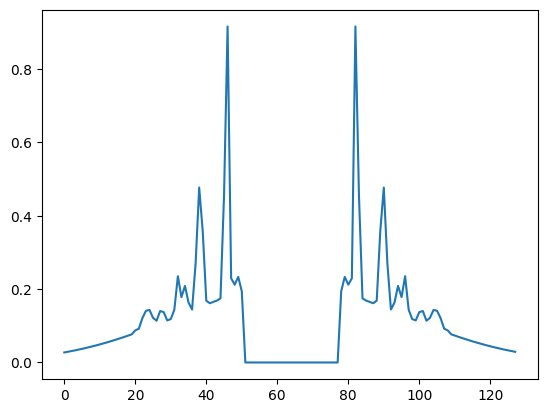

0.0878


In [ ]:

plt.imshow(Y[0][:,:,0])
plt.show()
plt.plot(Y[0][64,:,0])
plt.show()
print(uiso_labels[0])
plt.imshow(Y[-1][:,:,0])
plt.show()
plt.plot(Y[-1][64,:,0])
plt.show()
print(uiso_labels[-1])
plt.imshow(Y[-300][:,:,0])
plt.show()
plt.plot(Y[-300][64,:,0])
plt.show()
print(uiso_labels[-300])



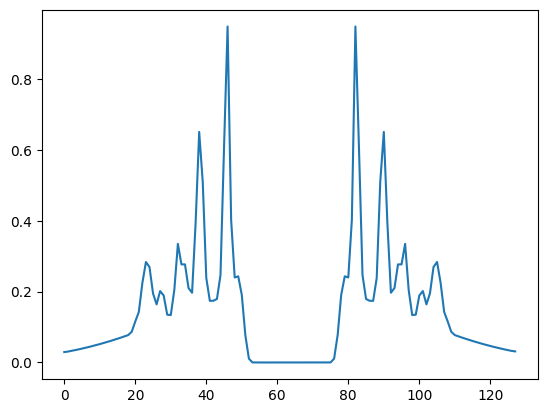

In [ ]:
plt.plot(Y[0][64,:,0])

plt.show()

In [ ]:
synth_arr = np.array(Y)
#synth_arr=synth_arr/np.max(synth_arr)
print(uiso_labels[104])
print(np.max(synth_arr[104]))

0.0178
1.0


In [ ]:
print(len(Y))
print(len(uiso_labels))

2076
2076


In [ ]:
"""
Open npy files with lab data


"""

transform = False

data_dir = "/content/drive/MyDrive/new_centered_uiso_labelled_images/"#"/content/drive/MyDrive/uiso_labelled_images/"#"/content/drive/MyDrive/nodifference_low_fluence/nodifference_low_fluence/"#"/content/drive/MyDrive/uiso_labelled_images/"#"/content/drive/MyDrive/differenced1/"#"/content/drive/MyDrive/uiso_labelled_images/" #"/content/drive/MyDrive/differenced_centered/differenced_centered/"#"/content/drive/MyDrive/differenced_labelled_actual/" #

uiso_vals = []
lab_images = []


#size_img = 128

Y_grid,X_grid = np.ogrid[:size_img,:size_img]
#dist_from_center = np.sqrt((X_grid-65)**2+(Y_grid-69)**2)
dist_from_center = np.sqrt((X_grid-64)**2+(Y_grid-64)**2)
mask = (dist_from_center > 13)

i= 0

for file in os.scandir(data_dir):
    if (file.path.split(data_dir)[1].split(".npy")[0] != 'labels'):

      #print(float(file.path.split("/content/drive/MyDrive/uiso_labelled_images/")[1].split(".npy")[0]))
      img = np.load(file.path,allow_pickle=True)
      image_arr_cropped = img[:,74:-74]


      image_from_array = Image.fromarray(image_arr_cropped)
      image_resized = np.array(image_from_array.resize((128,128))).astype("float32")

      """
      max_val = np.max(np.abs(image_resized))#,-np.min(image_resized))
      #print(max_val)
      if max_val == 0:
        continue
      for row_idx in range(size_img):
        for col_idx in range(size_img):
          image_resized[row_idx][col_idx] = image_resized[row_idx][col_idx]/max_val
      """





      image_resized[~mask] = 0


      #image_resized_normalized = (image_resized-np.mean(image_resized))/(np.max(image_resized) - np.min(image_resized))#(image_resized/np.max(image_resized)-0.5)*2
      #image_resized_normalized = image_resized_normalized - min(np.min(image_resized_normalized),0)

      image_resized_normalized = image_resized/np.max(image_resized)    # (image_resized/np.max(image_resized)-0.5)*2#image_resized/max(np.max(image_resized),-np.min(image_resized))#((image_resized)/(np.max(image_resized))-0.5)*2
      #

      if(transform):
        for augmentation in range(0,1):
          max_translation = 0#int(0.1*resolution)
          #for q in range(0,3):
          for q in range(0,7):
            M = np.float32([
            [1, 0, random.randint(-max_translation,max_translation)],
            [0, 1, random.randint(-max_translation,max_translation)]
            ])
            new_image = cv.warpAffine(image_resized_normalized, M, (resolution,resolution))
            #new_image[~mask] = 0

            #blurry_img_expanded=np.expand_dims(np.expand_dims(new_image,-1),0)

            #lab_images.append(blurry_img_expanded)
            lab_images.append(new_image)
            uiso_vals.append(float(file.path.split(data_dir)[1].split(".npy")[0]))
      else:

        lab_images.append(np.expand_dims(image_resized_normalized,-1))
        uiso_vals.append(float(file.path.split(data_dir)[1].split(".npy")[0]))




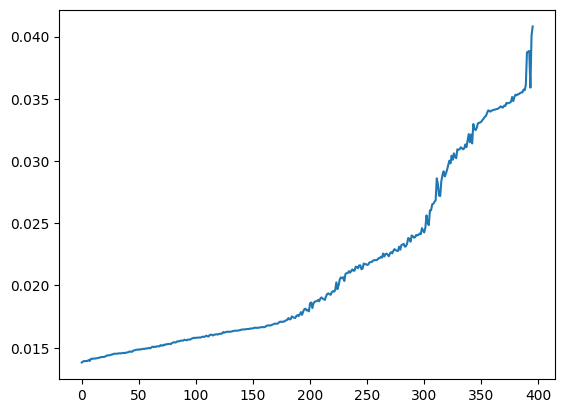

In [ ]:
plt.plot(uiso_vals)

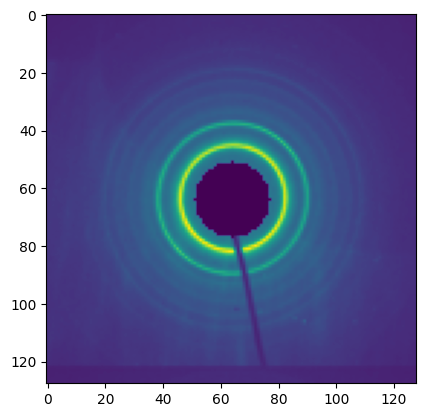

In [ ]:
plt.imshow(lab_images[1][:,:,0])
plt.show()


In [ ]:
#lab_images_low_uiso = lab_images
#uiso_vals_low_uiso = uiso_vals

In [ ]:
print(uiso_vals)

[0.01381413969542358, 0.013884667818901436, 0.01392602218910745, 0.013923904665729736, 0.013926347240866253, 0.013939643403087267, 0.014005479652644813, 0.013936210865158026, 0.014103409314355952, 0.014107422096111138, 0.014127663589704634, 0.014120761757119186, 0.014136593359678646, 0.014149389337276915, 0.014167522269518512, 0.014208809072850007, 0.014207298232063625, 0.014254692976661073, 0.014251603753820808, 0.014264221292120188, 0.014270214122988626, 0.01431496468760591, 0.014379353649081177, 0.014380067108335318, 0.014395968327025896, 0.014408080633508045, 0.014444204295833069, 0.01446566141699848, 0.014513035978562313, 0.014516666898559818, 0.014515673471105899, 0.014517256472494697, 0.014544909910258164, 0.014545746585616656, 0.014549863845552338, 0.014551605184026735, 0.01458636326598275, 0.014578733160836571, 0.01456868553949521, 0.014615283011833768, 0.014621032024859416, 0.014648803963829119, 0.014706903046736, 0.014677792425377511, 0.014671872859669716, 0.0147557205301937

In [ ]:
#uiso_vals_low_uiso = uiso_vals

In [ ]:
unchanged_lab_arr = np.array(lab_images)
#unchanged_lab_arr = unchanged_lab_arr/np.max(unchanged_lab_arr)

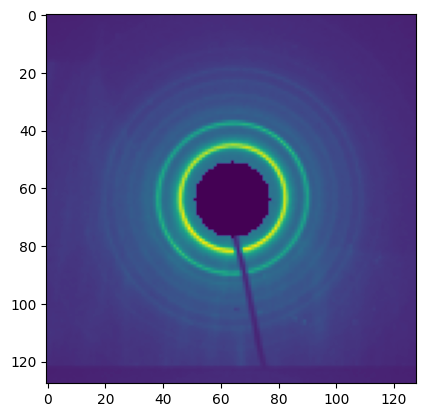

1.0
(128, 128, 1)


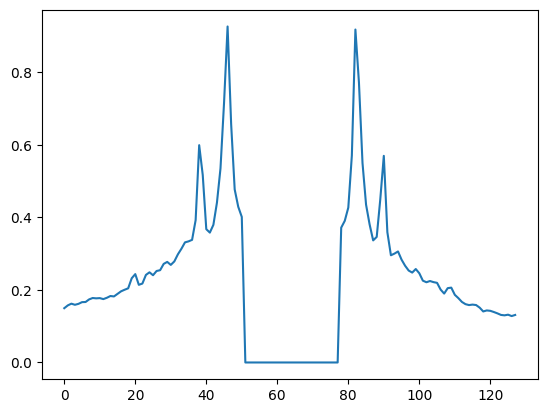

In [ ]:
plt.imshow(lab_images[0][:,:,0])
plt.show()
lab_img_arr = np.array(lab_images)
lab_img_arr=lab_img_arr/np.max(lab_img_arr)

#print(uiso_vals.index(0.020250832248233555)) - 223

print(np.max(lab_img_arr[0]))
print(np.shape(lab_img_arr[0]))
plt.plot(lab_img_arr[0][64,:,0])
plt.show()

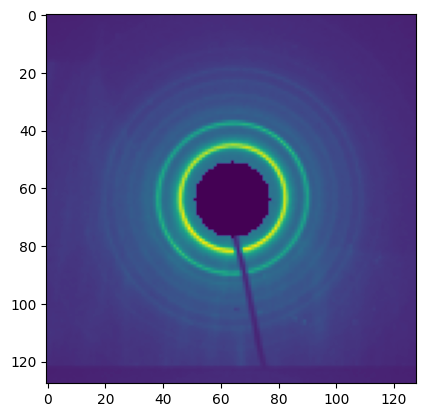

1.0
(128, 128, 1)


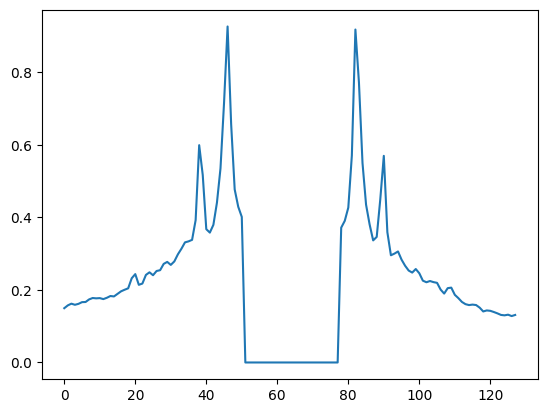

In [ ]:
plt.imshow(lab_images[0][:,:,0])
plt.show()
lab_img_arr = np.array(lab_images)
lab_img_arr=lab_img_arr/np.max(lab_img_arr)

#print(uiso_vals.index(0.020250832248233555)) - 223

print(np.max(lab_img_arr[0]))
print(np.shape(lab_img_arr[0]))
plt.plot(lab_img_arr[0][64,:,0])
plt.show()
#lab_img_arr = lab_img_arr*np.max(synth_arr[104])/np.max(lab_img_arr[223])

In [ ]:
print(len(Y))
print(len(uiso_labels))

2076
2076


In [ ]:
synthetic_image_dict = {}

for idx in range(len(uiso_labels)):
  synthetic_image_dict[uiso_labels[idx]] = Y[idx]

In [ ]:
labimgs_with_uiso = list(zip(uiso_vals,lab_images))

labimgs_with_uiso.sort(key=lambda a: a[0])

sorted_lab_uiso,sorted_labimgs = zip(*labimgs_with_uiso)

sorted_labimgs = np.expand_dims(sorted_labimgs,-1)
sorted_lab_uiso_arr = np.array(sorted_lab_uiso)

In [ ]:
lab_to_sim_mapping_uiso = {}

In [ ]:
vals_to_avoid = []

for idx in range(len(sorted_lab_uiso)):
  lab_uiso = sorted_lab_uiso[idx]

  best_gap = 1000
  best_idx = None
  for idx2 in range(len(uiso_labels)):
    if np.abs(uiso_labels[idx2]-lab_uiso) < best_gap:# and uiso_labels[idx2] not in vals_to_avoid:
      best_gap = np.abs(uiso_labels[idx2]-lab_uiso)
      best_idx = idx2
  if best_idx == None:
    lab_to_sim_mapping_uiso[lab_uiso] = None
    print(idx)
  else:
    lab_to_sim_mapping_uiso[lab_uiso] = uiso_labels[best_idx]
    vals_to_avoid.append(uiso_labels[best_idx])




In [ ]:
triple_list = []

for idx in range(len(sorted_lab_uiso)):
  lab_uiso = sorted_lab_uiso[idx]
  cm_uiso = lab_to_sim_mapping_uiso[lab_uiso]
  lab_image = sorted_labimgs[idx][:,:,:,0]
  cm_image = synthetic_image_dict[cm_uiso]
  triple_list.append([lab_image,cm_image,lab_uiso])
random.shuffle(triple_list)
labimgs_list_for_training,cm_list_for_training,uiso_list_for_training = zip(*triple_list)


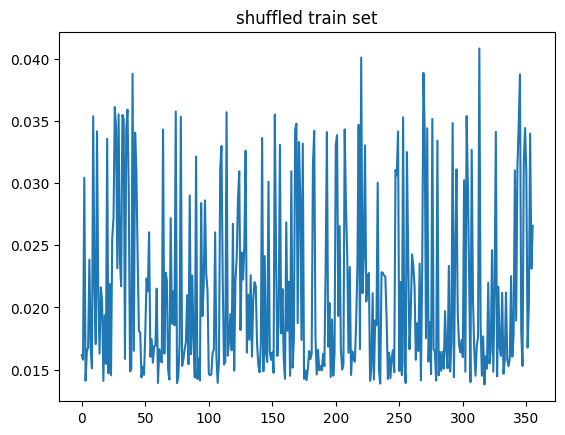

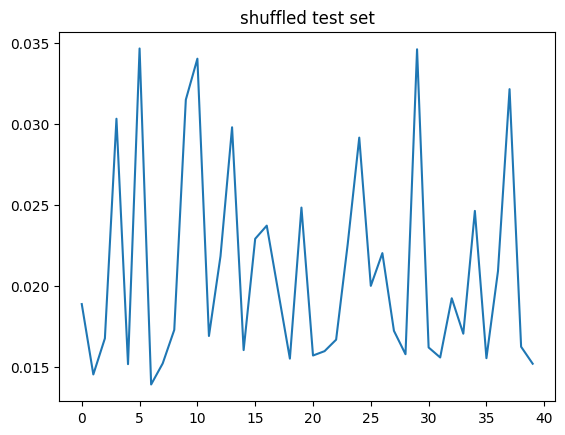

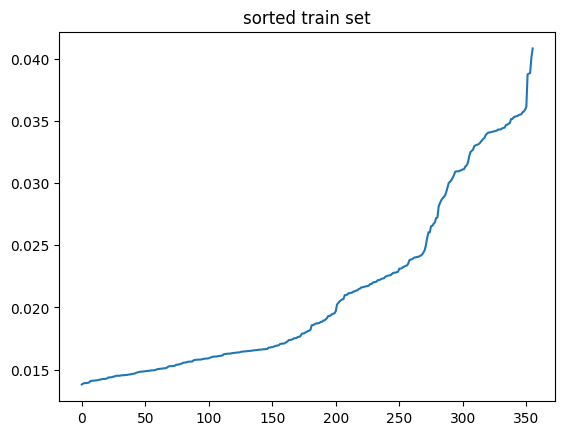

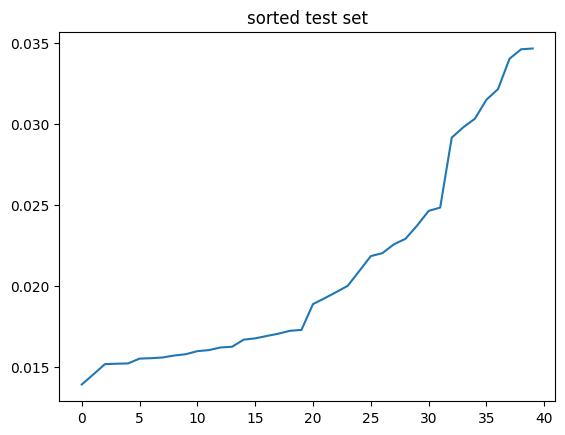

max in x train:  1.0
min in x train:  0.0
max in y train:  1.0
min in y train:  0.0


In [ ]:
train_test_ratio = 0.9
assert(len(cm_list_for_training) == len(labimgs_list_for_training))

#-------------
#X/Y were switched here.
Y_train, Y_test = cm_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))],cm_list_for_training[int(train_test_ratio*len(cm_list_for_training)):]
X_train, X_test = labimgs_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))],labimgs_list_for_training[int(train_test_ratio*len(cm_list_for_training)):]
labels_train, labels_test = np.array(uiso_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))]),np.array(uiso_list_for_training[int(train_test_ratio*len(cm_list_for_training)):])
#-------------

plt.plot(labels_train)
plt.title("shuffled train set")
plt.show()
plt.plot(labels_test)
plt.title("shuffled test set")
plt.show()




list_to_sort_train = list(zip(X_train,Y_train,labels_train))
list_to_sort_test = list(zip(X_test,Y_test,labels_test))

list_to_sort_train.sort(key=lambda a: a[2])
list_to_sort_test.sort(key=lambda a: a[2])

X_train,Y_train,labels_train = zip(*list_to_sort_train)
X_test,Y_test,labels_test = zip(*list_to_sort_test)

plt.plot(labels_train)
plt.title("sorted train set")
plt.show()
plt.plot(labels_test)
plt.title("sorted test set")
plt.show()

X_train_np_array = np.array(X_train).astype(np.float32)
print("max in x train: ",np.max(X_train_np_array))
print("min in x train: ",np.min(X_train_np_array))

Y_train_np_array = np.array(Y_train).astype(np.float32)
print("max in y train: ",np.max(Y_train_np_array))
print("min in y train: ",np.min(Y_train_np_array))

X_test_np_array = np.array(X_test).astype(np.float32)
X_test_np_array = X_test_np_array


Y_test_np_array = np.array(Y_test).astype(np.float32)
Y_test_np_array = Y_test_np_array

labels_train_np_array = np.expand_dims(np.array(labels_train).astype(np.float32),axis=-1)
labels_test_np_array = np.expand_dims(np.array(labels_test).astype(np.float32),axis=-1)

In [ ]:
print(Y_train_np_array.shape)
print(X_train_np_array.shape)
if X_train_np_array.shape != Y_train_np_array.shape:
  raise Exception("Array shapes don't match")

(356, 128, 128, 1)
(356, 128, 128, 1)


In [ ]:
train_dataset_GAN_2 = tf.data.Dataset.from_tensor_slices((X_train_np_array, Y_train_np_array,labels_train_np_array))
test_dataset_GAN_2 = tf.data.Dataset.from_tensor_slices((X_test_np_array, Y_test_np_array,labels_test_np_array))


train_dataset_GAN_2 = train_dataset_GAN_2.batch(34)#, drop_remainder=True)
test_dataset_GAN_2 = test_dataset_GAN_2.batch(34)#, drop_remainder=True)
print(train_dataset_GAN_2)
print(test_dataset_GAN_2)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [ ]:
def gen_shuffled_data():

  train_test_ratio = 0.9
  assert(len(cm_list_for_training) == len(labimgs_list_for_training))

  #-------------
  #X/Y were switched here.
  Y_train, Y_test = cm_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))],cm_list_for_training[int(train_test_ratio*len(cm_list_for_training)):]
  X_train, X_test = labimgs_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))],labimgs_list_for_training[int(train_test_ratio*len(cm_list_for_training)):]
  labels_train, labels_test = np.array(uiso_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))]),np.array(uiso_list_for_training[int(train_test_ratio*len(cm_list_for_training)):])
  #-------------

  """
  plt.plot(labels_train)
  plt.title("shuffled train set")
  plt.show()
  plt.plot(labels_test)
  plt.title("shuffled test set")
  plt.show()
  """



  list_to_sort_train = list(zip(X_train,Y_train,labels_train))
  list_to_sort_test = list(zip(X_test,Y_test,labels_test))

  list_to_sort_train.sort(key=lambda a: a[2])
  list_to_sort_test.sort(key=lambda a: a[2])

  X_train,Y_train,labels_train = zip(*list_to_sort_train)
  X_test,Y_test,labels_test = zip(*list_to_sort_test)

  """
  plt.plot(labels_train)
  plt.title("sorted train set")
  plt.show()
  plt.plot(labels_test)
  plt.title("sorted test set")
  plt.show()
  """
  X_train_np_array = np.array(X_train).astype(np.float32)#[:,:,:,0]
  #print("max in x train: ",np.max(X_train_np_array))
  #print("min in x train: ",np.min(X_train_np_array))

  Y_train_np_array = np.array(Y_train).astype(np.float32)
  #print("max in y train: ",np.max(Y_train_np_array))
  #print("min in y train: ",np.min(Y_train_np_array))

  X_test_np_array = np.array(X_test).astype(np.float32)#[:,:,:,0]
  X_test_np_array = X_test_np_array


  Y_test_np_array = np.array(Y_test).astype(np.float32)
  Y_test_np_array = Y_test_np_array

  labels_train_np_array = np.expand_dims(np.array(labels_train).astype(np.float32),axis=-1)
  labels_test_np_array = np.expand_dims(np.array(labels_test).astype(np.float32),axis=-1)

  print(Y_train_np_array.shape)
  print(X_train_np_array.shape)

  if X_train_np_array.shape != Y_train_np_array.shape:
    raise Exception("Array shapes don't match")

  train_dataset_GAN_2 = tf.data.Dataset.from_tensor_slices((X_train_np_array, Y_train_np_array,labels_train_np_array))
  test_dataset_GAN_2 = tf.data.Dataset.from_tensor_slices((X_test_np_array, Y_test_np_array,labels_test_np_array))


  train_dataset_GAN_2 = train_dataset_GAN_2.batch(34)#, drop_remainder=True)
  test_dataset_GAN_2 = test_dataset_GAN_2.batch(34)#, drop_remainder=True)
  #print(train_dataset_GAN_2)
  #print(test_dataset_GAN_2)

  return train_dataset_GAN_2,test_dataset_GAN_2


In [ ]:
def scatter_plot(arr,color_str='blue',title=None):
  plt.scatter(x = range(len(arr)),y=arr,color=color_str)
  if title is not None:
    plt.title(title)
  plt.show()
  plt.clf()


In [ ]:
def error_calcs(pred_cm,pred_gen,verbose=False,return_avg=False):
  error_vals = []
  num_sub_50 = 0
  num_sub_10 = 0
  num_sub_5 = 0
  for idx in range(len(pred_cm)):
    pred_val_cm = pred_cm[idx]
    pred_val_lab = pred_gen[idx]
    error = 100*(pred_val_cm-pred_val_lab)/pred_val_cm
    if abs(error) < 50:
      num_sub_50+=1
      if abs(error) < 10:
        num_sub_10+=1
        if abs(error) < 5:
          num_sub_5+=1

    error_vals.append(error)
  avg_val = sum(np.abs(error_vals))/len(error_vals)
  if verbose:
    scatter_plot(error_vals,title="error vals")
    print("average percent error: ",avg_val)
    print("within 50% of ground truth: ",num_sub_50/len(error_vals))
    print("within 10% of ground truth: ",num_sub_10/len(error_vals))
    print("within 5% of ground truth: ",num_sub_5/len(error_vals))

  if return_avg:
    return ([num_sub_10,num_sub_5],avg_val)
  else:
    return (num_sub_10,num_sub_5)

In [ ]:
#Defining neural net

def build_cnn_model():
  cnn_model = keras.Sequential([
      keras.layers.Conv2D(filters=18,kernel_size=(5,5),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=36,kernel_size=(5,5),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=72,kernel_size=(3,3),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=144,kernel_size=(2,2),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Flatten(),
      keras.layers.Dense(256, activation=tf.nn.relu),
      keras.layers.Dense(128, activation=tf.nn.relu),
      #keras.layers.Dropout(0.6),
      keras.layers.Dense(1)#, activation=tf.nn.softmax)
  ])

  return cnn_model

def compile_cnn(model,init_lr=0.001):
  initial_learning_rate = init_lr
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=300,
      decay_rate=0.96,
      staircase=True)
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
                  metrics = [linear_regression_equality])
  return model

"""
These metrics check the accuracy of the network.
The second metric (which has a larger allowed error) determines whether the network's prediction is 'in the ballpark'
"""
accepted_diff = 0.002
#error_accepted = 0.1
def linear_regression_equality(y_true, y_pred):
    """
    diff_arr = []
    for idx in range(len(y_true)):
      diff = K.abs(y_true[idx]-y_pred[idx])
      diff = diff / y_true[idx]
      if diff < error_accepted:
        diff_arr.append(1)
      else:
        diff_arr.append(0)
    return round(sum(diff_arr)/len(diff_arr),2)

    return error_calcs(y_true,y_pred,True)[1]
    """
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))


In [ ]:
def train(model,X_array,Y_array, EPOCHS=15):

  accuracy_values = []
  validation_accuracy_values= []
  loss_values = []
  validation_loss_values = []

  for epoch in range(0,EPOCHS):#epoch_to_load+EPOCHS+1):

    print("-------------STARTING EPOCH {}-------------".format(epoch+1))
    history = model.fit(X_array,Y_array,batch_size=30,epochs=10,validation_split=0.1,verbose=0)
    #Storing accuracy and loss values
    accuracy_values.append(history.history['linear_regression_equality'][0])
    validation_accuracy_values.append(history.history['val_linear_regression_equality'][0])
    loss_values.append(history.history['loss'][0])
    validation_loss_values.append(history.history['val_loss'][0])

  f1 = plt.figure()
  f2 = plt.figure()
  ax1 = f1.add_subplot(111)

  ax1.plot(accuracy_values, "-b",label = "train accuracy")
  ax1.plot(validation_accuracy_values, "-r",label = "test accuracy")
  ax1.legend()
  ax2 = f2.add_subplot(111)
  ax2.plot(loss_values, "-b",label = "train loss")
  ax2.plot(validation_loss_values, "-r",label = "test loss")
  ax2.set_ylim([0,validation_loss_values[1]])
  ax2.legend()
  plt.show()

In [ ]:
training_cnn = False
if (training_cnn):
  uiso_labels, radii, intensities = retrieve_data(uiso_lower_bound = 0#0.0138
                                                , uiso_increment= 0.0001#<- just for placeholder #0.0002#uiso_increment=0.0005
                                                ,uiso_upper_bound=0.5#uiso_upper_bound=0.1259#0.05
                                                ,intensity_scale=10)


  #uiso_rad_list = zip(uiso_labels,radii)

  #print(uiso_rad_list[0])

  images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_img_to_generate=4,deblurring=True,sub=True)
  #images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_augmentations=1,num_img_to_generate=1,deblurring=True,transform_image=False)

  #print(np.shape(images_uiso))
  images_uiso.sort(key=lambda a: a[1])

  images,uiso_labels = zip(*images_uiso)

  #Y,X = zip(*images)
  X,Y = zip(*images)

  print(len(X))

  X_array = np.array(X)
  X_array = X_array/np.max(np.abs(X_array))
  Y_array = np.array(uiso_labels).reshape(-1)

  print("input shape: {}".format(X_array.shape))
  print("label shape: {}".format(Y_array.shape))

----RETRIEVING DATA----
0.0%
0.0%
0.0%
0.0%
0.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
----DONE----


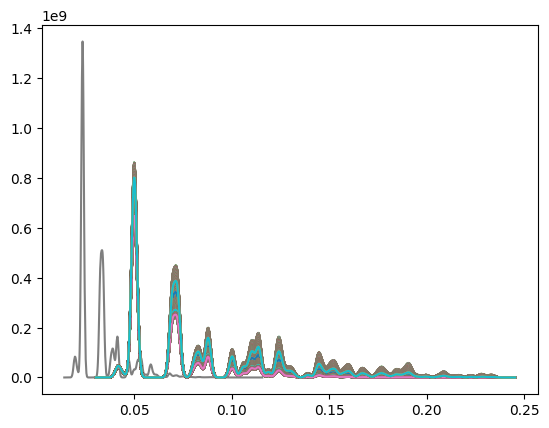

Have 860 datapoints for training
----GENERATING DIFFRACTION PATTERNS----
0.0%
0.0%
0.0%
0.0%
0.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
100.0%
100.0%
100.0%
100.0%
----DONE----
6880


<Figure size 640x480 with 0 Axes>

In [ ]:


uiso_labels_, radii_, intensities_ = retrieve_data(uiso_lower_bound = 0.01
                                                , uiso_increment= 0.0001#0.0005#<- just for placeholder #0.0002#uiso_increment=0.0005
                                                ,uiso_upper_bound=0.1#0.04#0.5#uiso_upper_bound=0.1259#0.05
                                                ,intensity_scale=10)

images_uiso = generate_diffraction_patterns(uiso_labels_,radii_,intensities_,False,num_img_to_generate=4,deblurring=True,sub=False,transform_image=True)
#images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_augmentations=1,num_img_to_generate=1,deblurring=True,transform_image=False)

#print(np.shape(images_uiso))
#images_uiso.sort(key=lambda a: a[1])
random.shuffle(images_uiso)
images_,uiso_labels_ = zip(*images_uiso)

#Y,X = zip(*images)
X_,Y_ = zip(*images_)

Y_ = np.array(Y_)
Y_ = Y_/np.max(Y_)
uiso_labels_np_arr_ = np.array(uiso_labels_)
print(np.shape(Y_)[0])


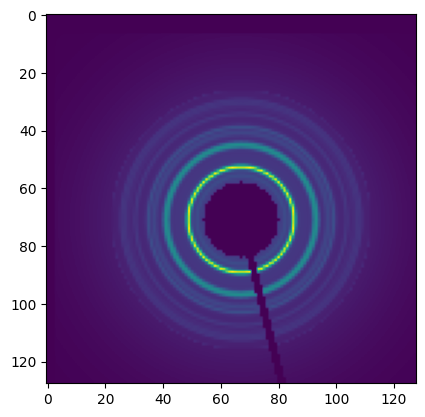

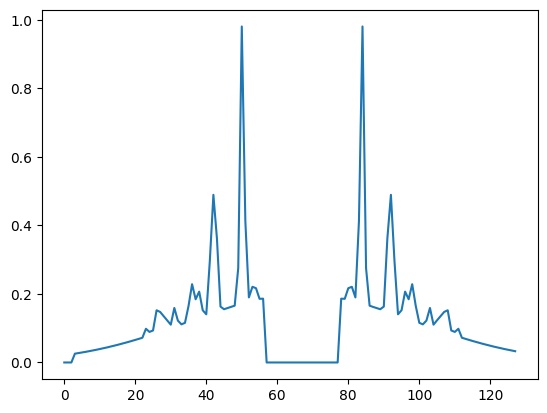

In [ ]:
plt.imshow(Y_[0][:,:,0])
plt.show()
plt.plot(Y_[0][64,:,0])
plt.show()

In [ ]:
print(len(images_))

6880


In [ ]:
print(len(uiso_labels))

2076


In [ ]:
"""
cnn:
has training set + test set, randomly chosen from CM images

GAN:
it is trained on Lab,CM pairs. Lab is input, CM is output
To maximize data used so far, we haven't removed any lab images to use as test set
So to test GAN performance so far, we've just reinput the training set into the GAN to get an output
This was fine till now, because the GAN couldn't even overfit to this data, it failed miserably
Now, it's starting to show real progress, so we may need to change this, but it comes at the cost of less data in the training set

As such, for every image output by GAN, it is likely very similar to some CM image in the training set for the CNN.
If the CNN overfits, it'll memorize these images and their uiso
So, for a 'bad' and overfit CNN, it'll give a higher uiso accuracy.

Check:
  - CNN training set =/= GAN target set
  - Evaluate CNN performance, look at training/test accuracy, try to maximize test set accuracy (can create infinite # of training/test images for CNN)
  - Check performance of overall GAN/CNN setup
  - Experiment with different train/test ratios (90/10 on low fluence, randomize and do multiple redo's)
  -

Binary test, 10% error, 5% error
"""

"\ncnn: \nhas training set + test set, randomly chosen from CM images\n\nGAN:\nit is trained on Lab,CM pairs. Lab is input, CM is output\nTo maximize data used so far, we haven't removed any lab images to use as test set\nSo to test GAN performance so far, we've just reinput the training set into the GAN to get an output\nThis was fine till now, because the GAN couldn't even overfit to this data, it failed miserably\nNow, it's starting to show real progress, so we may need to change this, but it comes at the cost of less data in the training set\n\nAs such, for every image output by GAN, it is likely very similar to some CM image in the training set for the CNN. \nIf the CNN overfits, it'll memorize these images and their uiso\nSo, for a 'bad' and overfit CNN, it'll give a higher uiso accuracy.\n\nCheck:\n  - CNN training set =/= GAN target set\n  - Evaluate CNN performance, look at training/test accuracy, try to maximize test set accuracy (can create infinite # of training/test images

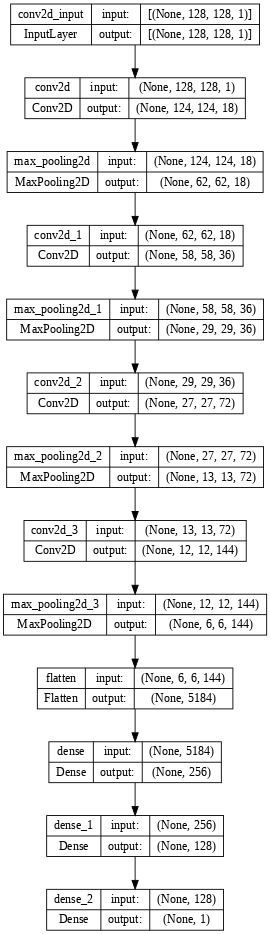

In [ ]:
model = compile_cnn(build_cnn_model(),0.001)
model.build(input_shape=(None,128,128,1))
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
#model = keras.models.load_model("/content/drive/MyDrive/cnn weights/cnn1_weights.h5",custom_objects={'linear_regression_equality': linear_regression_equality})


-------------STARTING EPOCH 1-------------
-------------STARTING EPOCH 2-------------
-------------STARTING EPOCH 3-------------
-------------STARTING EPOCH 4-------------
-------------STARTING EPOCH 5-------------
-------------STARTING EPOCH 6-------------
-------------STARTING EPOCH 7-------------
-------------STARTING EPOCH 8-------------
-------------STARTING EPOCH 9-------------
-------------STARTING EPOCH 10-------------
-------------STARTING EPOCH 11-------------


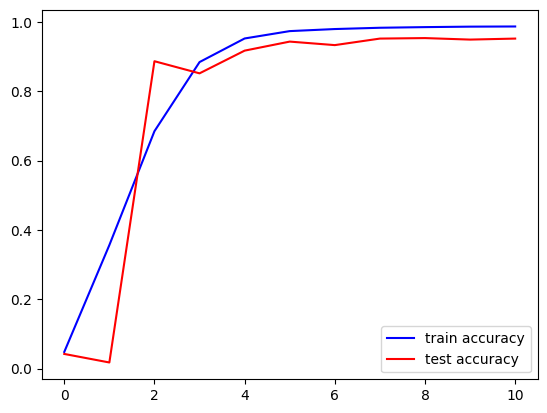

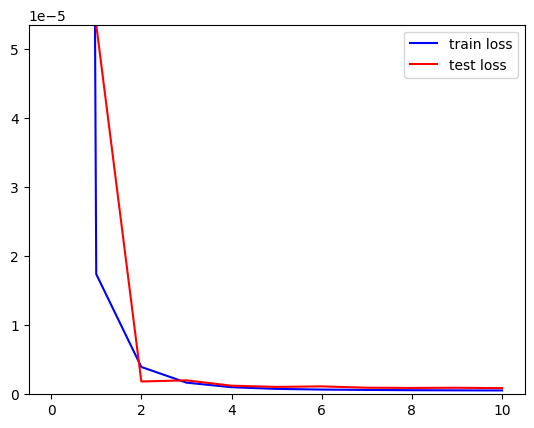

should see perfect alignment


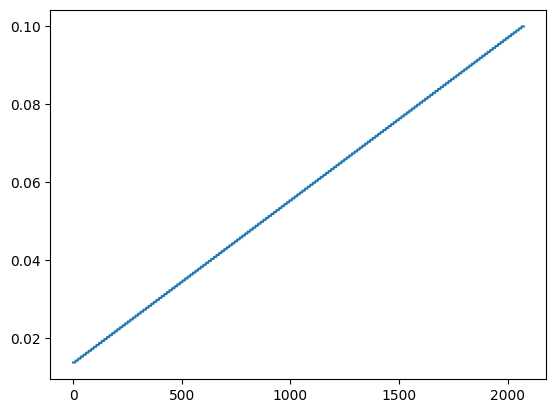

65/65 [==============================] - 1s 4ms/step


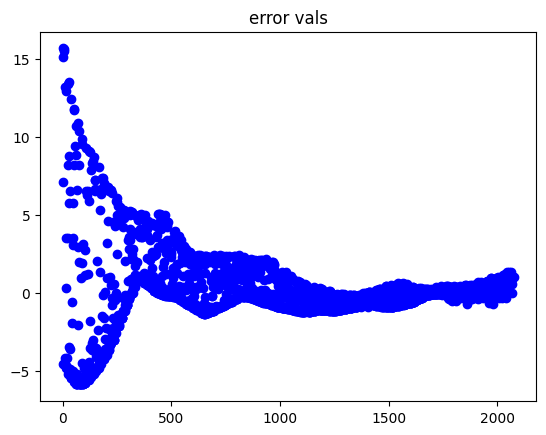

average percent error:  [1.377594]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.9932562620423893
within 5% of ground truth:  0.9325626204238922


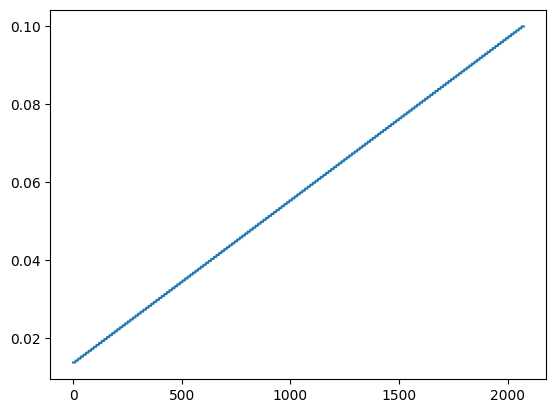

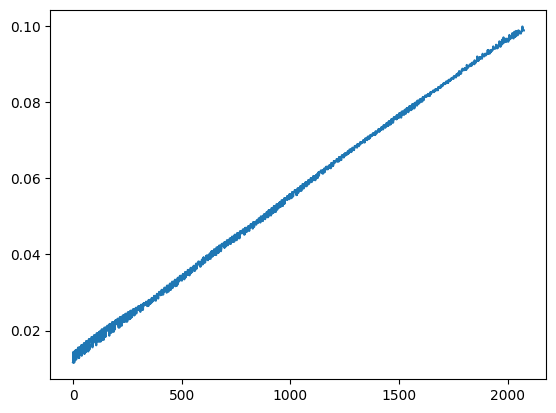

'\nfor reps in range(1):\n  train(model,Y_,uiso_labels_np_arr_,EPOCHS=2)\n  print("should see perfect alignment")\n  plt.plot(uiso_labels_np_arr_)\n  plt.show()\n  preds = model.predict(Y_)\n  plt.plot(preds)\n  plt.show()\n'

In [ ]:
for reps in range(1):
  train(model,np.array(Y_),np.array(uiso_labels_np_arr_),EPOCHS=11)
  print("should see perfect alignment")
  plt.plot(uiso_labels)
  plt.show()
  preds = model.predict(synth_arr)

  #pred_cm = model.predict(cm_imgs_arr)
  error_calcs(uiso_labels,preds,verbose=True)
  #error_calcs(labels_train,pred_cm,verbose=True)
  plt.plot(uiso_labels)
  plt.show()
  plt.plot(preds)
  plt.show()

  #plt.plot(pred_cm)
  #plt.show()
  #plt.plot(labels_train)
  #plt.show()
"""
for reps in range(1):
  train(model,Y_,uiso_labels_np_arr_,EPOCHS=2)
  print("should see perfect alignment")
  plt.plot(uiso_labels_np_arr_)
  plt.show()
  preds = model.predict(Y_)
  plt.plot(preds)
  plt.show()
"""
#model.save("cnn1_weights.h5")
#cnn_model = model

In [ ]:
#model.save("cnn1_weights.h5")

-------------STARTING EPOCH 1-------------
-------------STARTING EPOCH 2-------------
-------------STARTING EPOCH 3-------------
-------------STARTING EPOCH 4-------------
-------------STARTING EPOCH 5-------------
-------------STARTING EPOCH 6-------------
-------------STARTING EPOCH 7-------------
-------------STARTING EPOCH 8-------------
-------------STARTING EPOCH 9-------------
-------------STARTING EPOCH 10-------------
-------------STARTING EPOCH 11-------------


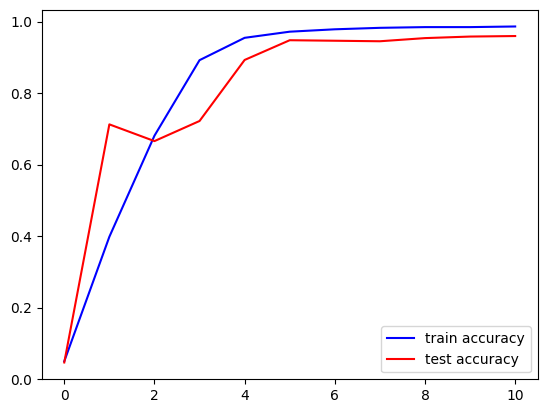

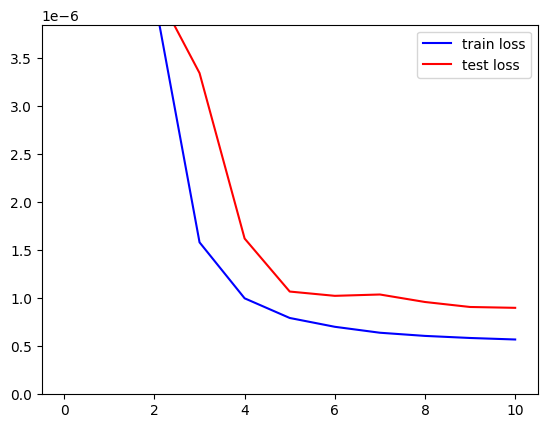

should see perfect alignment


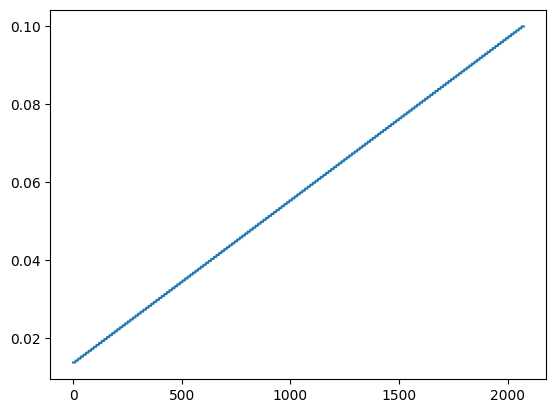

65/65 [==============================] - 0s 3ms/step


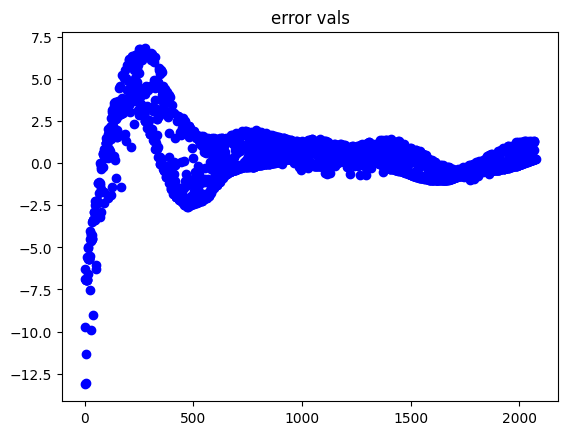

average percent error:  [1.1594392]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.9985549132947977
within 5% of ground truth:  0.9648362235067437


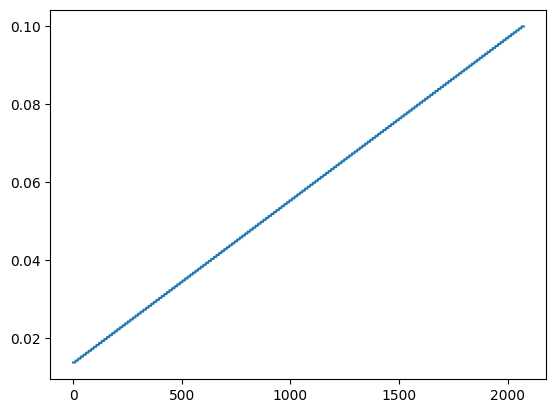

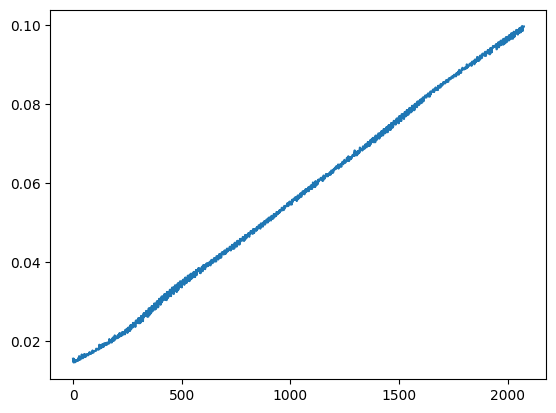

'\nfor reps in range(1):\n  train(model,Y_,uiso_labels_np_arr_,EPOCHS=2)\n  print("should see perfect alignment")\n  plt.plot(uiso_labels_np_arr_)\n  plt.show()\n  preds = model.predict(Y_)\n  plt.plot(preds)\n  plt.show()\n'

In [ ]:
model_2 = compile_cnn(build_cnn_model(),0.001)
model_2.build(input_shape=(None,128,128,1))
#model_2 = keras.models.load_model("/content/drive/MyDrive/cnn weights/cnn2_weights.h5",custom_objects={'linear_regression_equality': linear_regression_equality})

tf.keras.utils.plot_model(model_2, show_shapes=True, dpi=64)

for reps in range(1):

  train(model_2,np.array(Y_),np.array(uiso_labels_np_arr_),EPOCHS=11)
  print("should see perfect alignment")
  plt.plot(uiso_labels)
  plt.show()
  preds = model_2.predict(synth_arr)

  #pred_cm = model.predict(cm_imgs_arr)
  error_calcs(uiso_labels,preds,verbose=True)
  #error_calcs(labels_train,pred_cm,verbose=True)
  plt.plot(uiso_labels)
  plt.show()
  plt.plot(preds)
  plt.show()

  #plt.plot(pred_cm)
  #plt.show()
  #plt.plot(labels_train)
  #plt.show()
"""
for reps in range(1):
  train(model,Y_,uiso_labels_np_arr_,EPOCHS=2)
  print("should see perfect alignment")
  plt.plot(uiso_labels_np_arr_)
  plt.show()
  preds = model.predict(Y_)
  plt.plot(preds)
  plt.show()
"""

In [ ]:
cnn_model = model_2

In [ ]:
#cnn_model.save('alc_weights.h5')


In [ ]:
"""
for reps in range(3):
  train(model,synth_arr,np.array(uiso_labels),EPOCHS=2)
  print("should see perfect alignment")
  plt.plot(uiso_labels)
  plt.show()
  preds = model.predict(synth_arr)
  plt.plot(preds)
  plt.show()

  print("now for unchanged lab imgs")
  preds = model.predict(unchanged_lab_arr)
  plt.scatter(range(len(preds)),preds)
  plt.show()
  print("now for renorm'd lab imgs")
  preds = model.predict(lab_img_arr)
  plt.scatter(range(len(preds)),preds)
  plt.show()
  print("test data plot")
  plt.plot(uiso_vals)
  plt.show()

"""

'\nfor reps in range(3):\n  train(model,synth_arr,np.array(uiso_labels),EPOCHS=2)\n  print("should see perfect alignment")\n  plt.plot(uiso_labels)\n  plt.show()\n  preds = model.predict(synth_arr)\n  plt.plot(preds)\n  plt.show()\n  \n  print("now for unchanged lab imgs")\n  preds = model.predict(unchanged_lab_arr)\n  plt.scatter(range(len(preds)),preds)\n  plt.show()\n  print("now for renorm\'d lab imgs")\n  preds = model.predict(lab_img_arr)\n  plt.scatter(range(len(preds)),preds)\n  plt.show()\n  print("test data plot")\n  plt.plot(uiso_vals)\n  plt.show()\n\n'

In [ ]:
"""
plt.imshow(Y[0][:,:,0])
plt.show()

train_test_ratio = 0.8
assert(len(Y) == len(X))
X_train, X_test = X[0:int(train_test_ratio*len(X))],X[int(train_test_ratio*len(X)):]
Y_train, Y_test = Y[0:int(train_test_ratio*len(X))],Y[int(train_test_ratio*len(X)):]

X_train_np_array = np.array(X_train).astype(np.float32)
Y_train_np_array = np.array(Y_train).astype(np.float32)

X_test_np_array = np.array(X_test).astype(np.float32)
Y_test_np_array = np.array(Y_test).astype(np.float32)

X_np_array = np.array(X).astype(np.float32)
Y_np_array = np.array(Y).astype(np.float32)
uiso_labels_arr = np.array(uiso_labels).astype(np.float32)
print(X_np_array.shape)
print(Y_np_array.shape)
print(uiso_labels_arr.shape)

uiso_dataset = tf.data.Dataset.from_tensor_slices((X_np_array,Y_np_array,uiso_labels_arr)).batch(200, drop_remainder=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np_array, Y_train_np_array))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_np_array, Y_test_np_array))


train_dataset = train_dataset.batch(200, drop_remainder=True)
test_dataset = test_dataset.batch(200, drop_remainder=True)
print(test_dataset)
print(train_dataset)
"""


'\nplt.imshow(Y[0][:,:,0])\nplt.show()\n\ntrain_test_ratio = 0.8\nassert(len(Y) == len(X))\nX_train, X_test = X[0:int(train_test_ratio*len(X))],X[int(train_test_ratio*len(X)):]\nY_train, Y_test = Y[0:int(train_test_ratio*len(X))],Y[int(train_test_ratio*len(X)):]\n\nX_train_np_array = np.array(X_train).astype(np.float32)\nY_train_np_array = np.array(Y_train).astype(np.float32)\n\nX_test_np_array = np.array(X_test).astype(np.float32)\nY_test_np_array = np.array(Y_test).astype(np.float32)\n\nX_np_array = np.array(X).astype(np.float32)\nY_np_array = np.array(Y).astype(np.float32)\nuiso_labels_arr = np.array(uiso_labels).astype(np.float32)\nprint(X_np_array.shape)\nprint(Y_np_array.shape)\nprint(uiso_labels_arr.shape)\n\nuiso_dataset = tf.data.Dataset.from_tensor_slices((X_np_array,Y_np_array,uiso_labels_arr)).batch(200, drop_remainder=True)\n\ntrain_dataset = tf.data.Dataset.from_tensor_slices((X_train_np_array, Y_train_np_array))\ntest_dataset = tf.data.Dataset.from_tensor_slices((X_test_

In [ ]:
#from: https://www.tensorflow.org/tutorials/generative/pix2pix

In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    #downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation=tf.nn.relu)#'sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

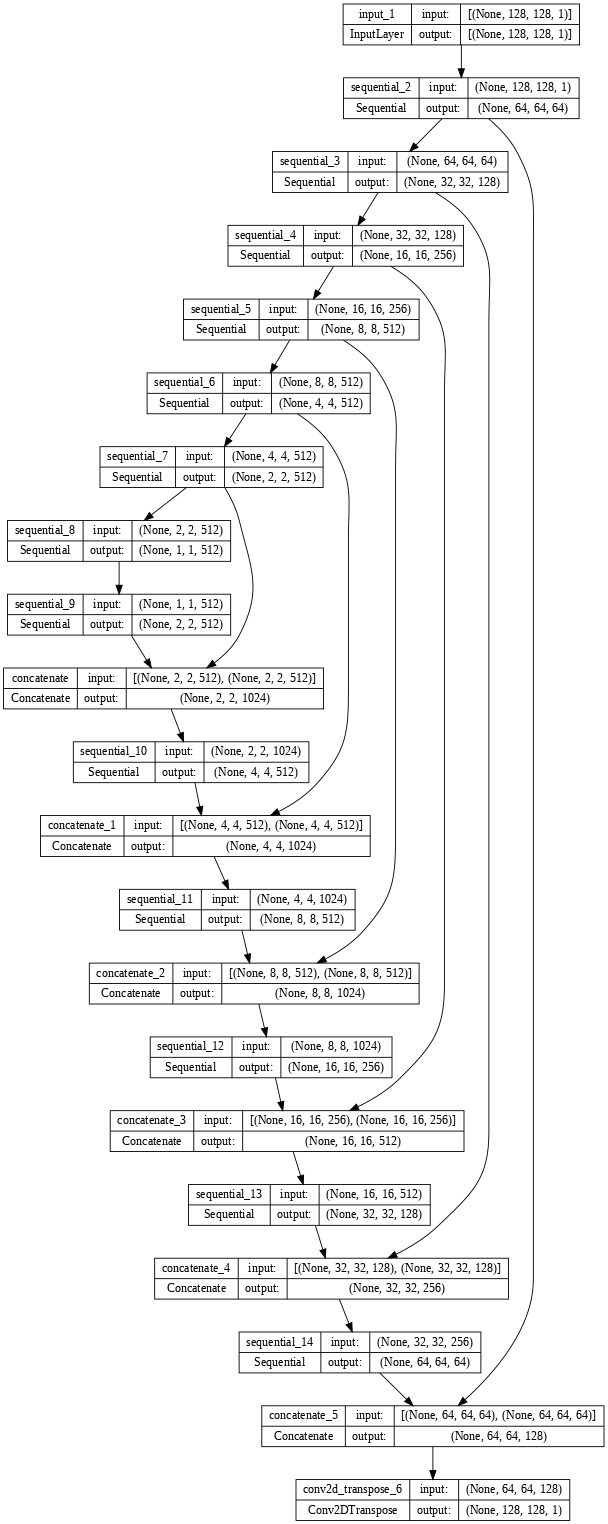

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
#1,inf for same img

In [ ]:
#.3, 15 for diff imgs

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.losses import MSE
from skimage.filters import gaussian
import random
#from config import *


SSIM_FACTOR = -15.0#15.0#20.0
PSNR_FACTOR = -7.0
ADVERSARIAL_LOSS_FACTOR = 1.0
SP_LOSS_FACTOR = 1.1*0.5
PIXEL_LOSS_FACTOR = 0.01


def batch_ssim_psnr_sum(batch_truth, batch_fake):
    ssim = tf.reduce_mean(tf.image.ssim(batch_truth, batch_fake, 1.0))
    ssim = tf.multiply(ssim, SSIM_FACTOR)
    psnr = tf.reduce_mean(tf.image.psnr(batch_truth, batch_fake, 1.0))
    psnr = tf.multiply(psnr, PSNR_FACTOR)
    return tf.add(ssim, psnr)


def batch_ssim_psnr_show(batch_truth, batch_fake):
    ssim = tf.reduce_mean(tf.image.ssim(batch_truth, batch_fake, 1.0))
    psnr = tf.reduce_mean(tf.image.psnr(batch_truth, batch_fake, 1.0))
    return ssim, psnr

In [ ]:
for step, (input_image, target,uiso_val) in train_dataset_GAN_2.repeat().take(2000).enumerate():
  #print(batch_ssim_psnr_sum(target, target)) #ssim
  #print(batch_ssim_psnr_show(input_image, target)[1]) #psnr
  #print(model(target))
  #print(uiso_val)
  #print(cnn_model(generator(input_image)))
  #print(cnn_model(target))
  #print(uiso_val)
  #print(tf.reduce_mean(tf.math.abs(tf.math.subtract(generator(input_image), target)))*100)
  #print(100000*tf.reduce_mean(tf.math.abs(tf.math.subtract(model(target), uiso_val))))
  #print(model(target),uiso_val)
  #print(tf.math.abs(tf.math.subtract(100*model(target), 100*uiso_val)))
  break

In [ ]:
#tf.math.squared_difference([1,1],[3,3])

In [ ]:
#tf.reduce_mean(tf.math.squared_difference(X_train_np_array[0], X_train_np_array[1]))

In [ ]:
LAMBDA = 100
#CNN_loss_coeff = 900
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target,uiso_val,use_CNN,CNN_loss_coeff):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  """
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  """

  l1_loss = tf.reduce_mean(tf.math.squared_difference(target, gen_output))

  #l1_loss = tf.reduce_mean(tf.math.abs(tf.math.subtract(target, gen_output)))

  SPLOSS = tf.abs(tf.multiply(batch_ssim_psnr_sum(target, gen_output), SP_LOSS_FACTOR))

  CNN_uiso_error = tf.reduce_mean(tf.math.abs(tf.math.subtract(cnn_model(gen_output), uiso_val)))

  #total_gen_loss = gan_loss + (LAMBDA * l1_loss) + 0*SPLOSS/5 + 3000*CNN_uiso_error
  if not use_CNN:
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + SPLOSS/5
  else:
    #total_gen_loss = gan_loss + (LAMBDA * l1_loss) + 5*30*3000*CNN_uiso_error + SPLOSS/5
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + CNN_loss_coeff*CNN_uiso_error + SPLOSS/5
  """
  print("gan loss: ",gan_loss)
  print("l1_loss: ",l1_loss)
  print("SPLOSS: ",SPLOSS)
  """


  return total_gen_loss, gan_loss, LAMBDA * l1_loss,CNN_loss_coeff*CNN_uiso_error,SPLOSS/5


#can add PSNR to this

In [ ]:
"""

Setup C:
  3 CNNs, 1 Generator

  Generator: takes in lab image, outputs CM image
  Discriminator: takes in - (lab image, CM image) or (lab image, generated image), used for loss
  Auxiliary Loss CNN: takes in - (generated image), outputs uiso. Trained on CM images, used for loss
  Verifier CNN: takes in - generated image, outputs uiso. Trained on CM images



"""

'\n\nSetup C:\n  3 CNNs, 1 Generator\n  \n  Generator: takes in lab image, outputs CM image\n  Discriminator: takes in - (lab image, CM image) or (lab image, generated image), used for loss\n  Auxiliary Loss CNN: takes in - (generated image), outputs uiso. Trained on CM images, used for loss\n  Verifier CNN: takes in - generated image, outputs uiso. Trained on CM images\n\n\n\n'

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

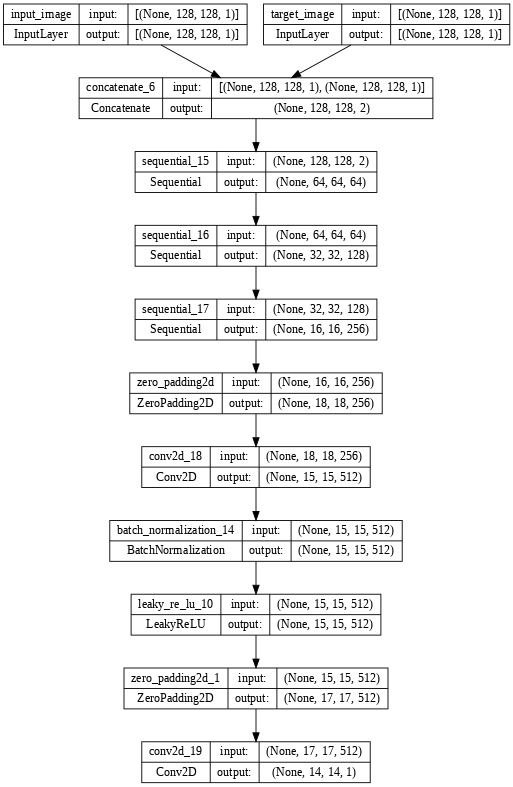

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input, tar=None,gen_only=False,num=3):
  if gen_only:
    prediction = model(test_input, training=True)
    return prediction
  else:
    prediction = model(test_input, training=True)
    for j in range(num):
      plt.figure(figsize=(15, 15))
      idx = np.random.randint(0,np.shape(test_input)[0])
      mse_loss_1 = tf.reduce_mean(tf.abs(tar[idx] - prediction[idx]))
      print("\nMSE between gen output and target: {}".format(mse_loss_1))

      mse_loss_2 = tf.reduce_mean(tf.abs(tar[idx] - test_input[idx]))
      print("MSE between gen output and input: {}".format(mse_loss_2))

      mse_loss_3 = tf.reduce_mean(tf.abs(test_input[idx] - prediction[idx]))
      print("MSE between input and target: {}".format(mse_loss_3))

      display_list = [test_input[idx,:,:,0], tar[idx,:,:,0], prediction[idx][:,:,0]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']
      print("Max: {}".format(np.max(prediction[idx])))
      print("Min: {}".format(np.min(prediction[idx])))
      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i],cmap='gray')
        plt.axis('off')
      plt.show()



In [ ]:

"""
for example_input, example_target in test_dataset.take(1):
  print(example_input[0,:,:,0].shape)

"""

'\nfor example_input, example_target in test_dataset.take(1):\n  print(example_input[0,:,:,0].shape)\n\n'

In [ ]:
print(len([[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1]]))

[100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100]

[[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],
 [-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],
 [-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],
 [-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1]]

20


[[-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-20.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1],
 [-50.0, -2.0, 1.1]]

In [ ]:
print("restore cnn")
#h+=1

restore cnn


In [ ]:
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
folder_name = "good_cnn"
checkpoint_dir = "/content/drive/MyDrive/AI for UED/GAN Weights/Pix2Pix Checkpoints/"+folder_name+"/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

log_dir="/content/drive/MyDrive/AI for UED/GAN Weights/Pix2Pix Checkpoints/"+folder_name+"/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
#h+=1

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

CNN:  120
experiment:  0
starting
(356, 128, 128, 1)
(356, 128, 128, 1)

epoch:  1
2/2 [==============================] - 0s 5ms/step


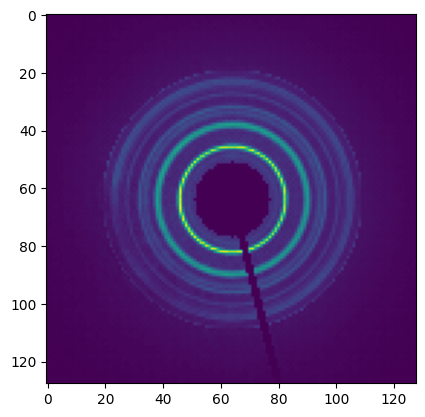

TRAIN PERFORMANCE: 


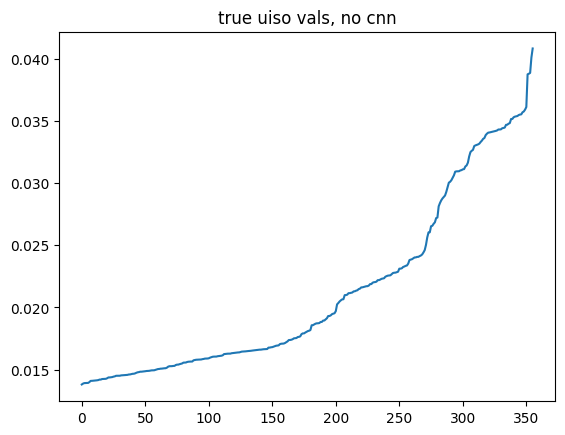

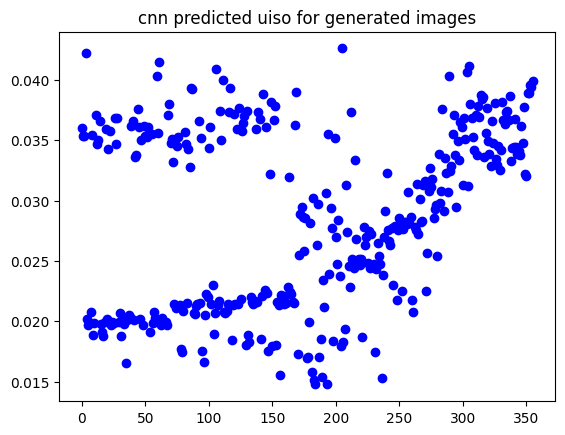

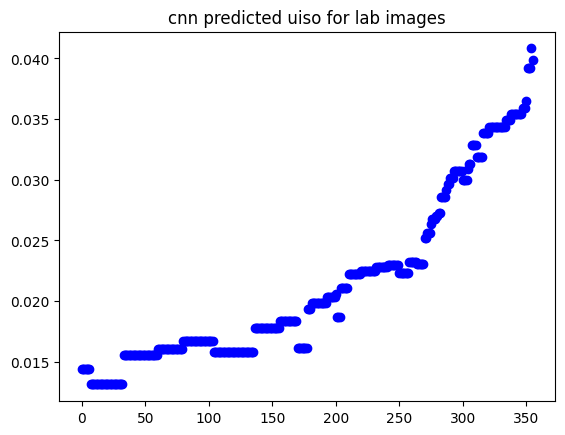

train perf


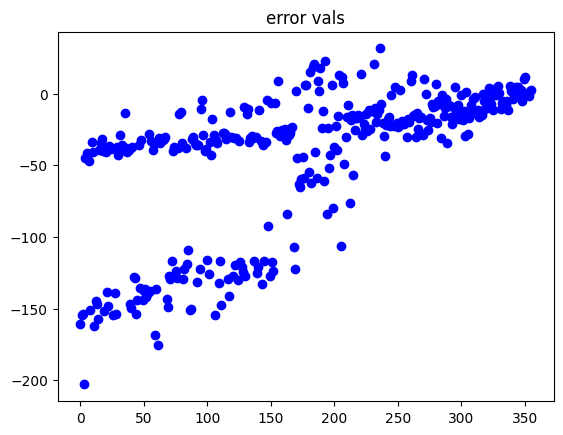

average percent error:  [45.614628]
within 50% of ground truth:  0.7556179775280899
within 10% of ground truth:  0.199438202247191
within 5% of ground truth:  0.10674157303370786
non analytic


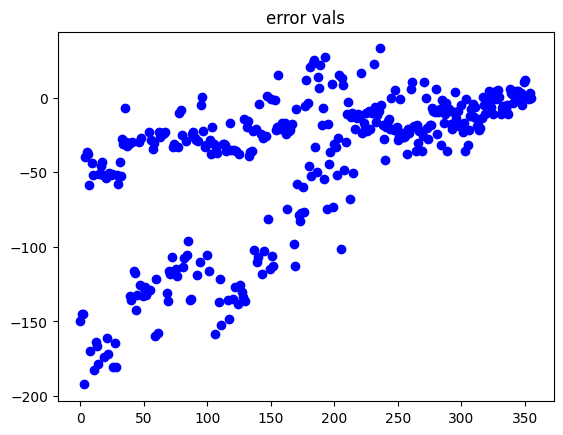

average percent error:  [44.857586]
within 50% of ground truth:  0.7247191011235955
within 10% of ground truth:  0.21629213483146068
within 5% of ground truth:  0.1151685393258427
train perf ALC


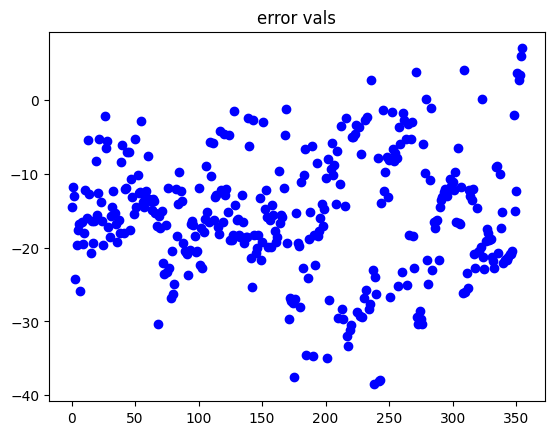

average percent error:  [15.769134]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.2303370786516854
within 5% of ground truth:  0.10112359550561797


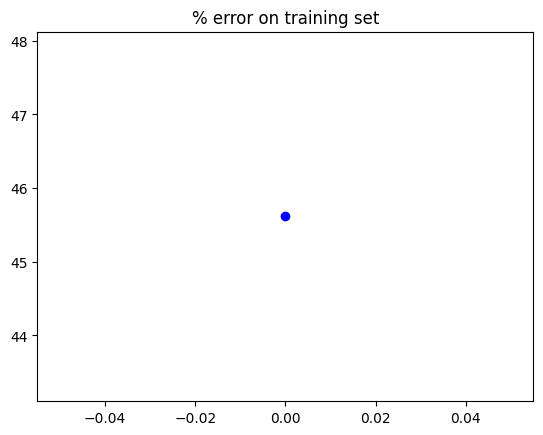

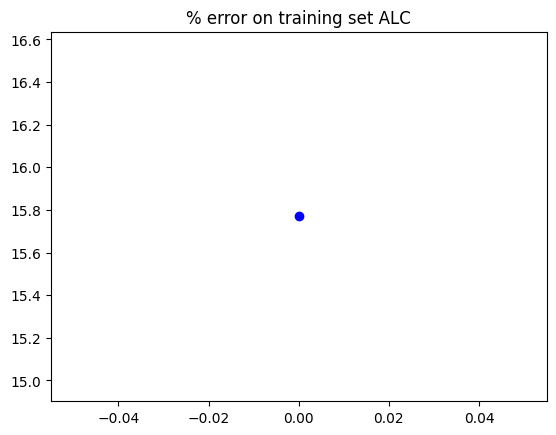

TEST PERFORMANCE: 


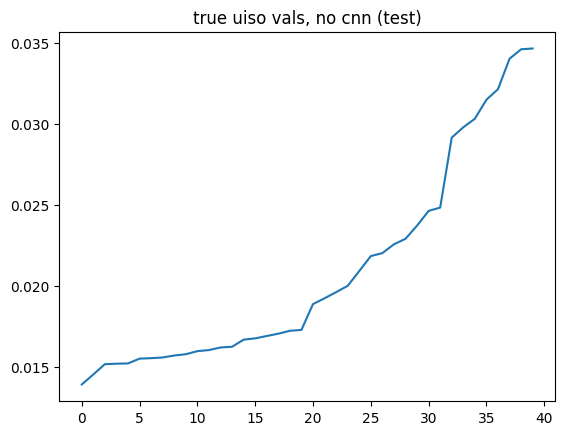

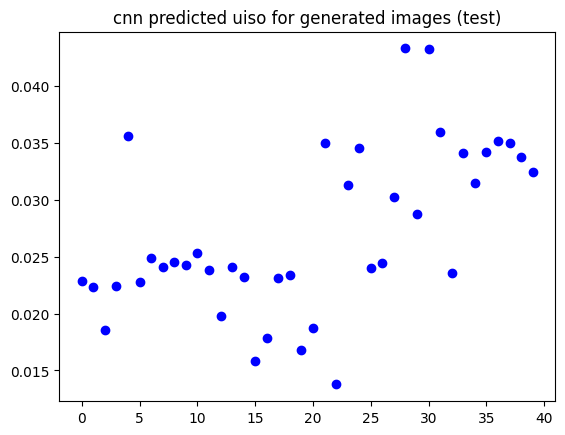

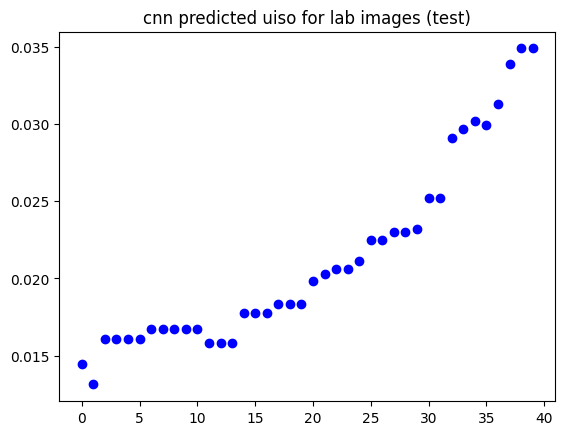

analytic


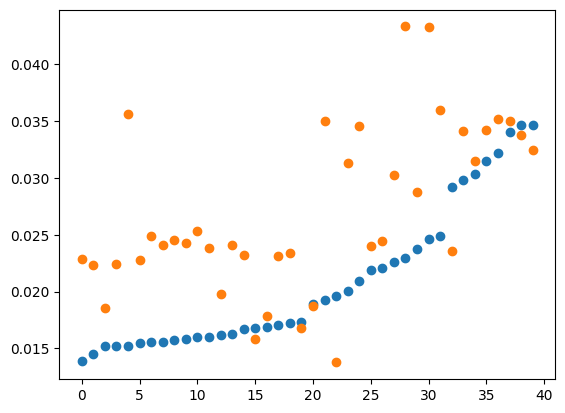

cnn output for cm and gen


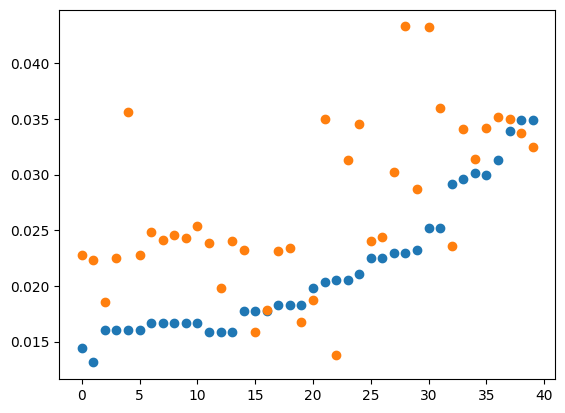

analytic


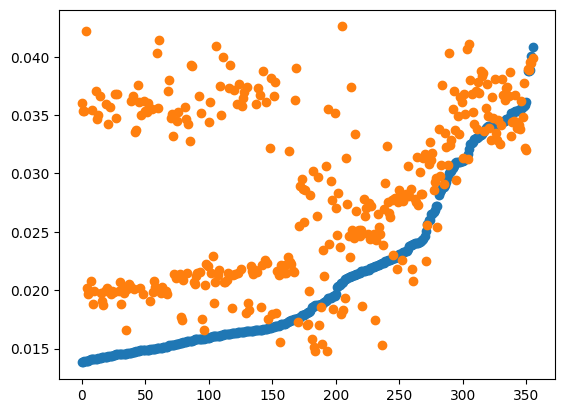

cnn output for cm and gen


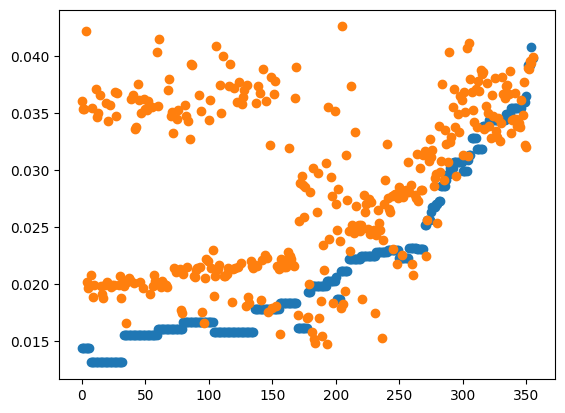

test perf


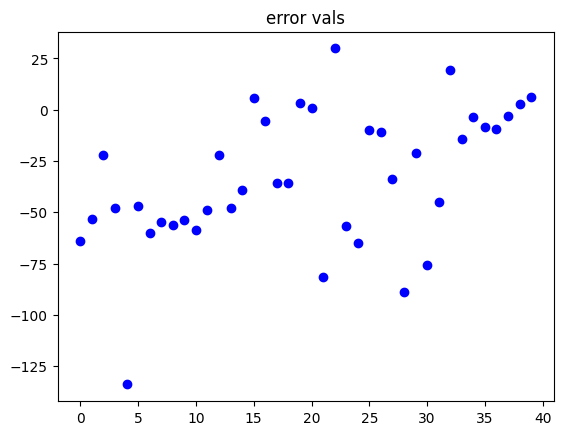

average percent error:  [37.021023]
within 50% of ground truth:  0.675
within 10% of ground truth:  0.25
within 5% of ground truth:  0.125
non analytic


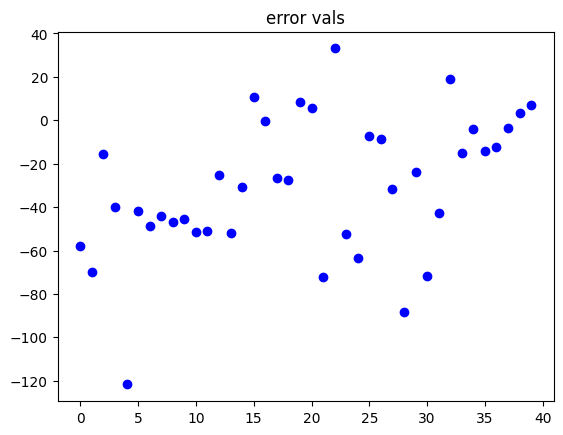

average percent error:  [34.90765]
within 50% of ground truth:  0.725
within 10% of ground truth:  0.225
within 5% of ground truth:  0.1
test perf ALC


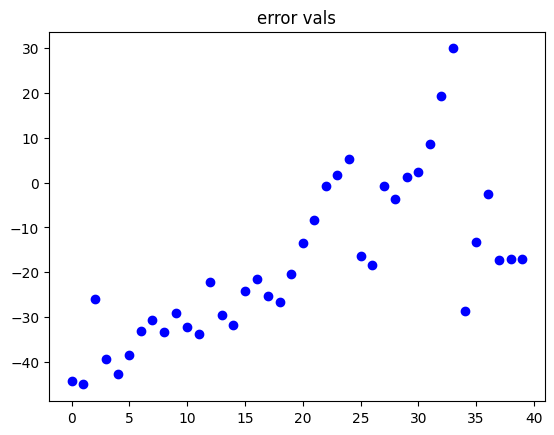

average percent error:  [21.379322]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.25
within 5% of ground truth:  0.175


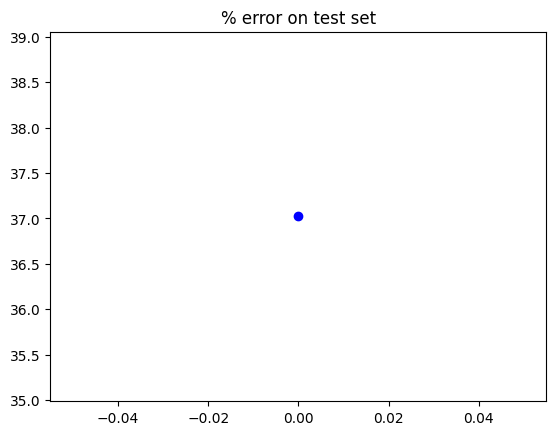

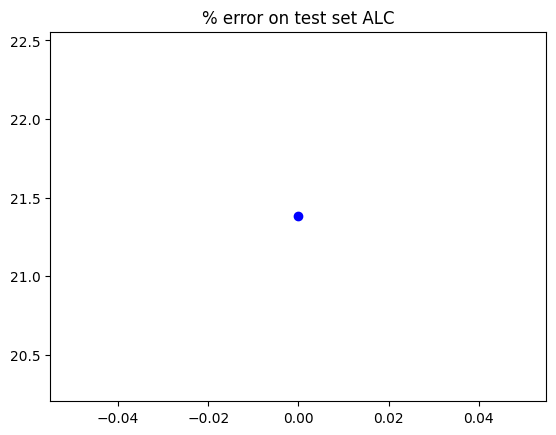

2/2 [==============================] - 0s 7ms/step


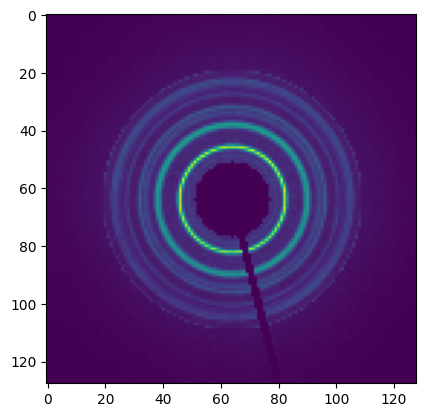

TRAIN PERFORMANCE: 


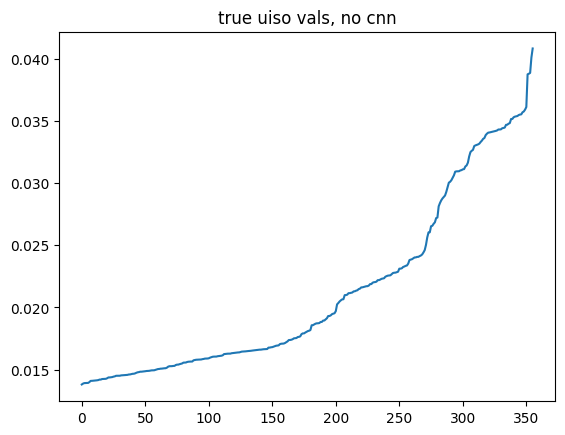

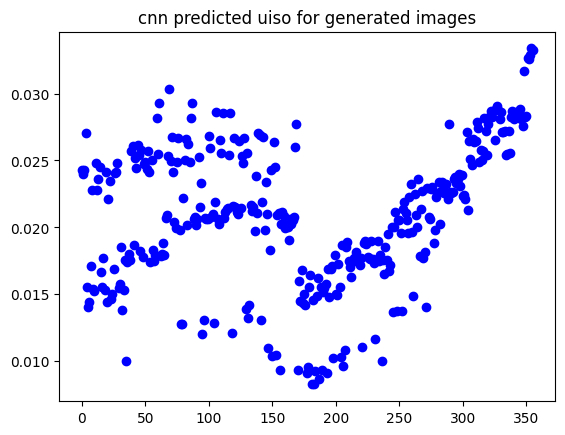

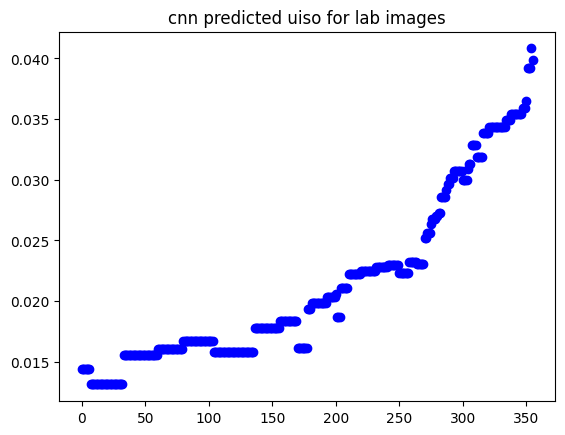

train perf


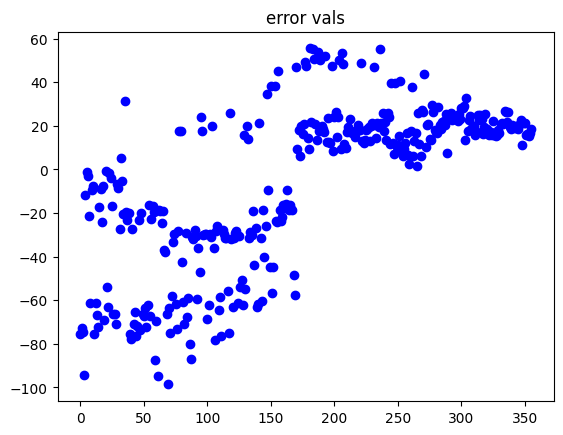

average percent error:  [30.690035]
within 50% of ground truth:  0.7949438202247191
within 10% of ground truth:  0.08426966292134831
within 5% of ground truth:  0.019662921348314606
non analytic


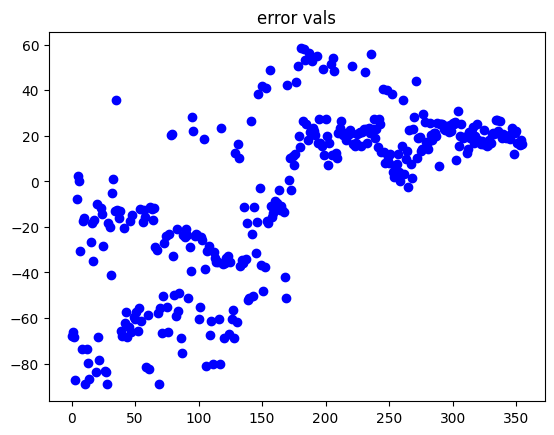

average percent error:  [29.821953]
within 50% of ground truth:  0.797752808988764
within 10% of ground truth:  0.08146067415730338
within 5% of ground truth:  0.03932584269662921
train perf ALC


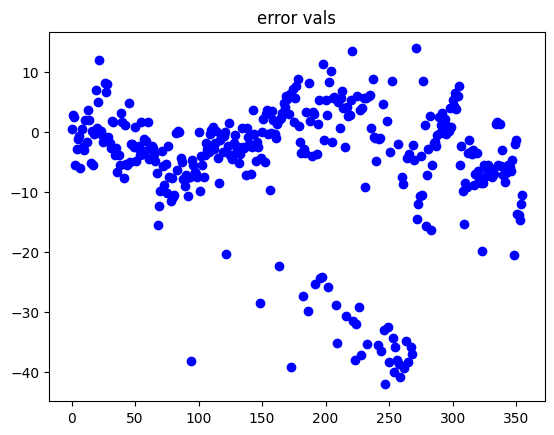

average percent error:  [7.6401753]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.8230337078651685
within 5% of ground truth:  0.5337078651685393


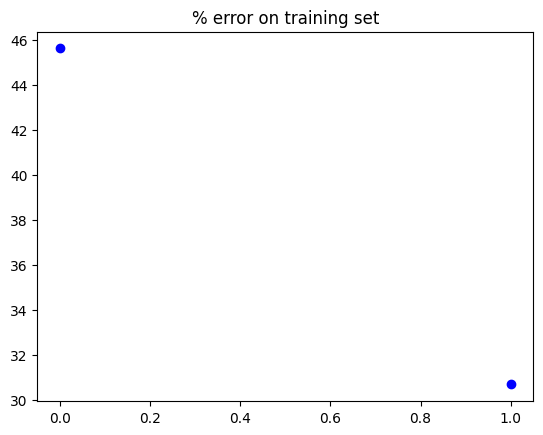

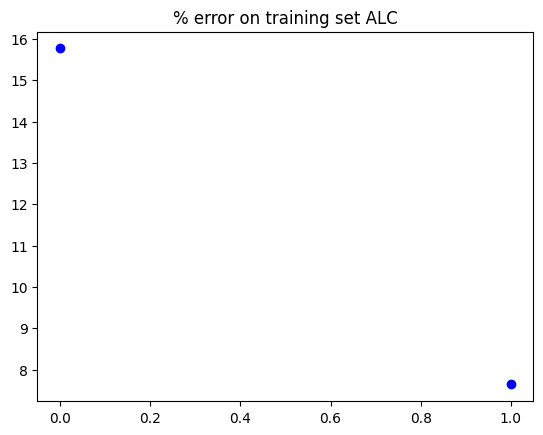

TEST PERFORMANCE: 


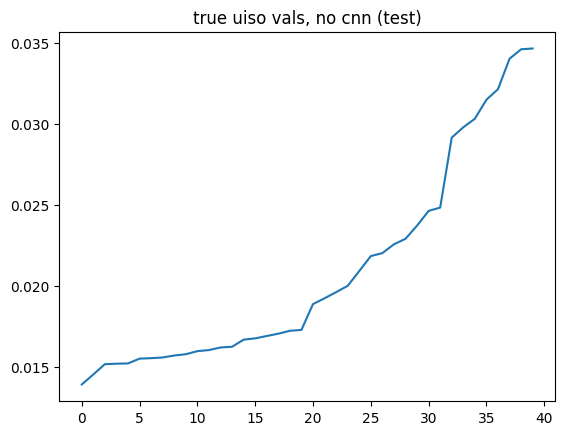

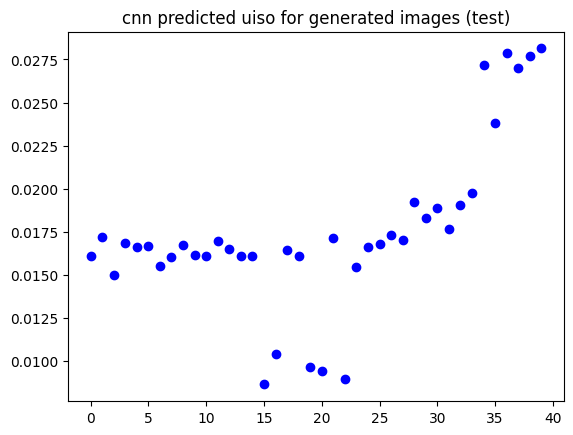

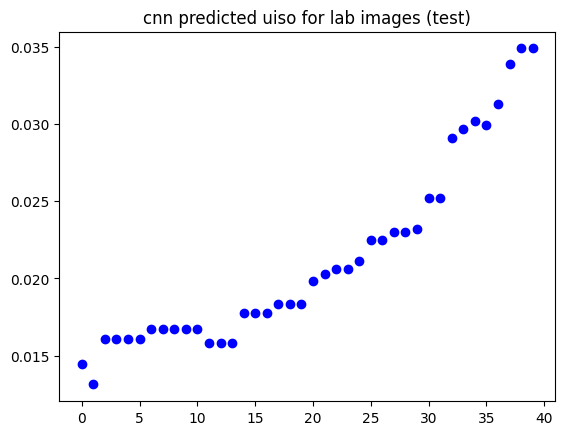

analytic


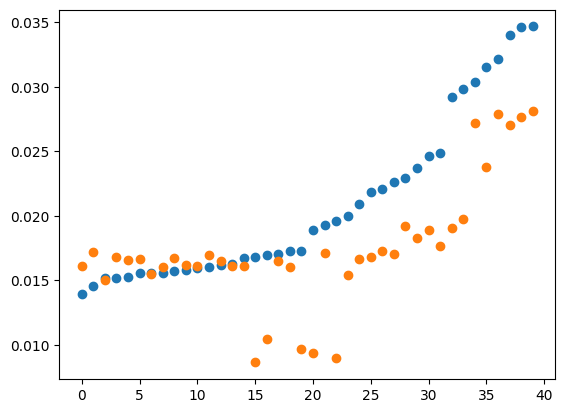

cnn output for cm and gen


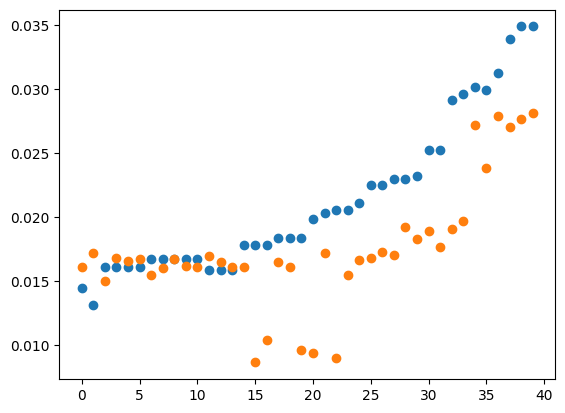

analytic


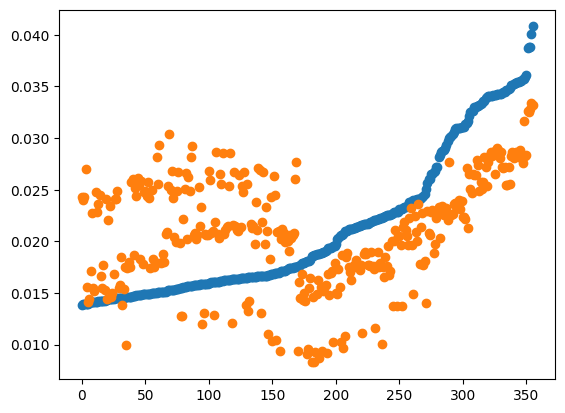

cnn output for cm and gen


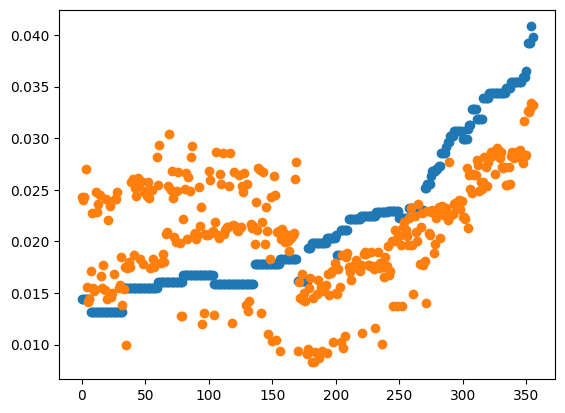

test perf


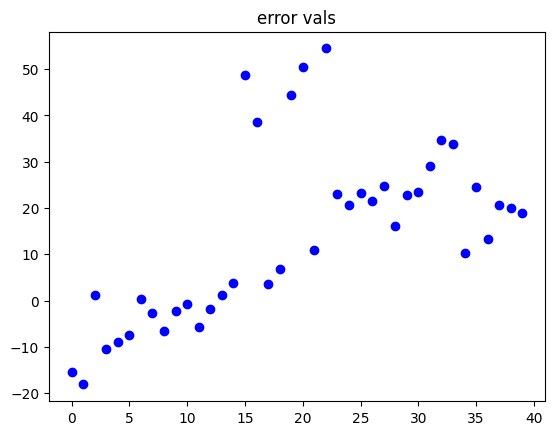

average percent error:  [18.11723]
within 50% of ground truth:  0.95
within 10% of ground truth:  0.35
within 5% of ground truth:  0.225
non analytic


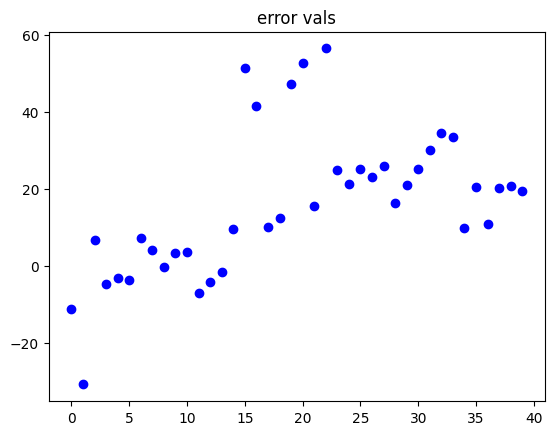

average percent error:  [19.309622]
within 50% of ground truth:  0.925
within 10% of ground truth:  0.35
within 5% of ground truth:  0.225
test perf ALC


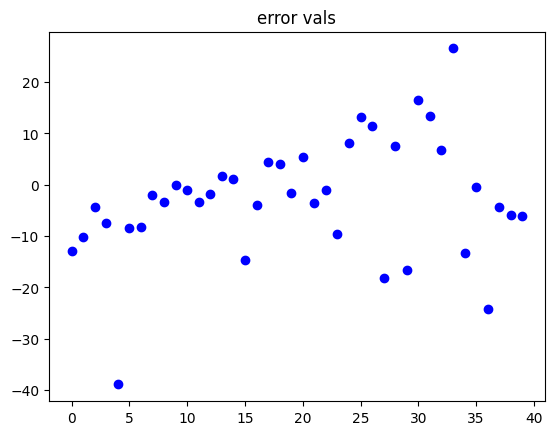

average percent error:  [8.6528]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.675
within 5% of ground truth:  0.425


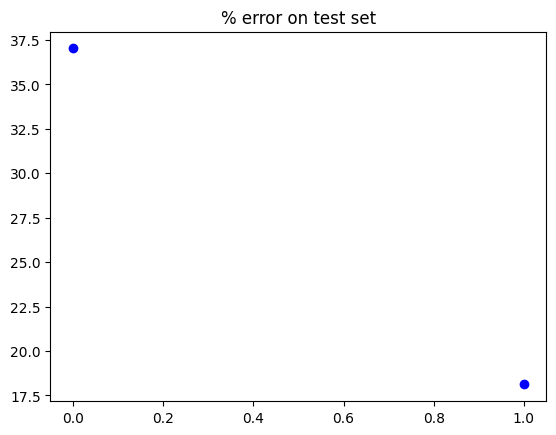

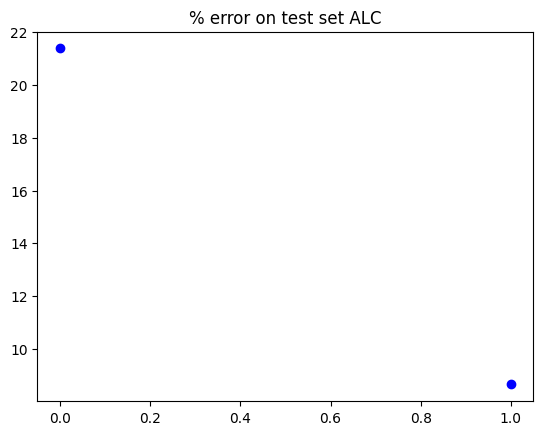

2/2 [==============================] - 0s 9ms/step


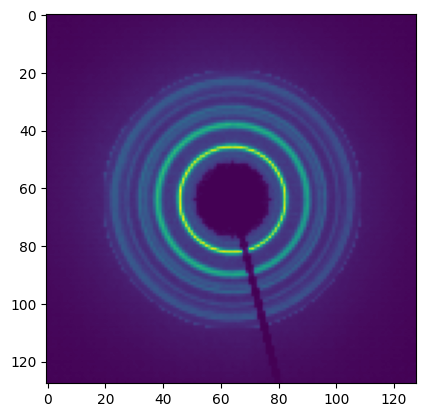

TRAIN PERFORMANCE: 


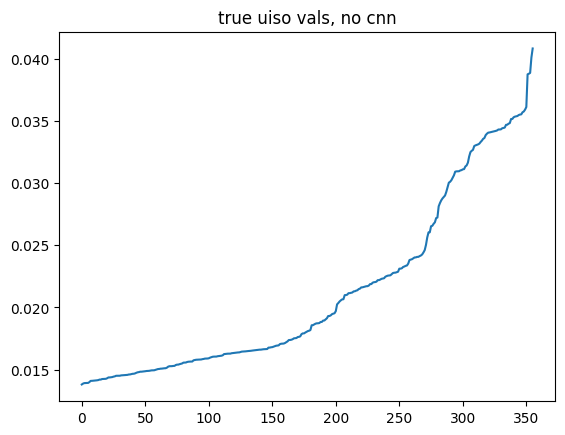

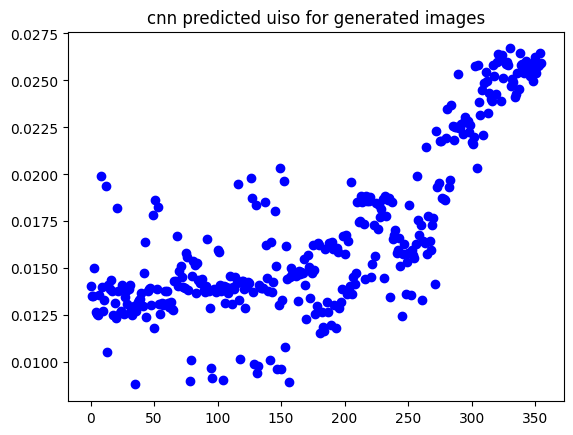

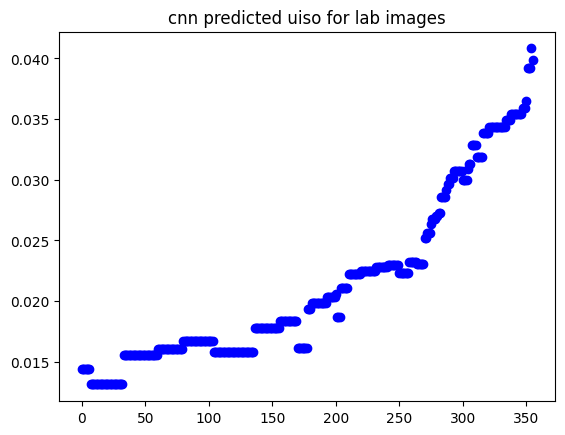

train perf


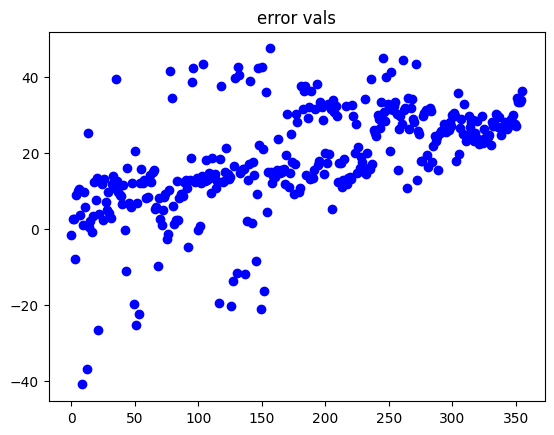

average percent error:  [20.147194]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.1797752808988764
within 5% of ground truth:  0.07584269662921349
non analytic


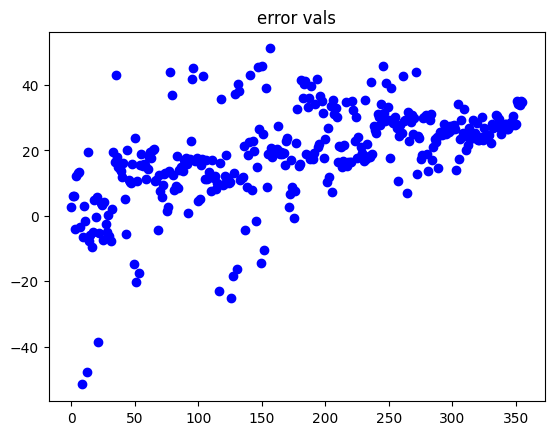

average percent error:  [21.015457]
within 50% of ground truth:  0.9943820224719101
within 10% of ground truth:  0.16292134831460675
within 5% of ground truth:  0.06741573033707865
train perf ALC


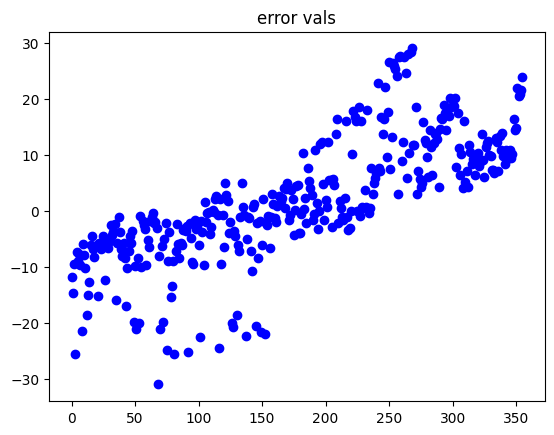

average percent error:  [8.846751]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.651685393258427
within 5% of ground truth:  0.38202247191011235


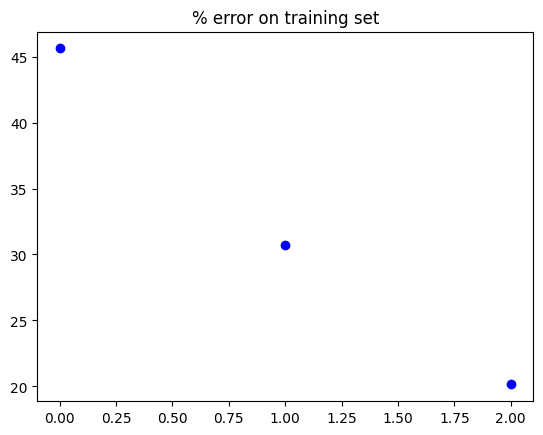

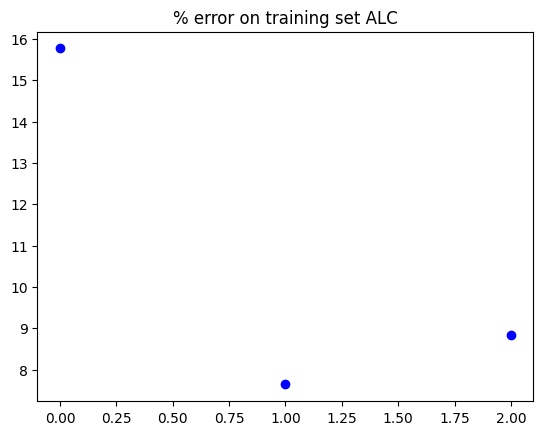

TEST PERFORMANCE: 


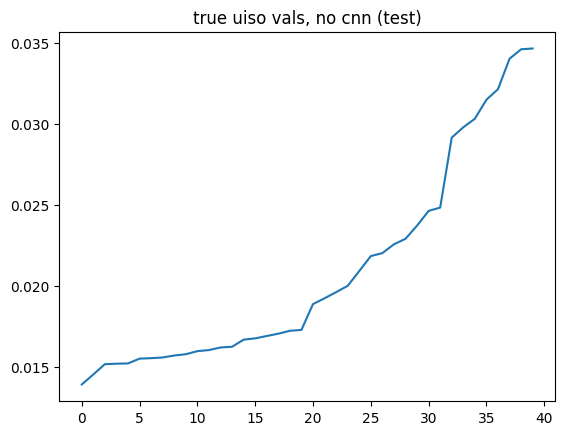

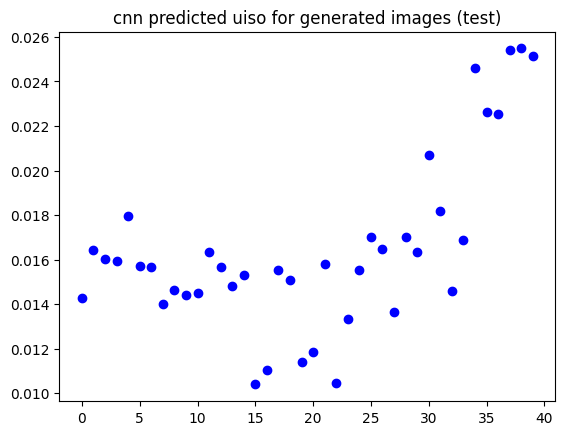

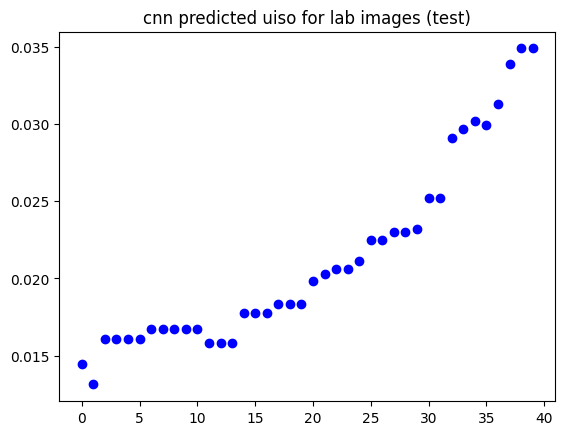

analytic


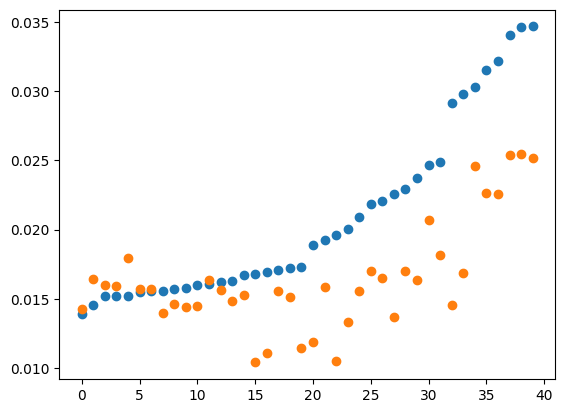

cnn output for cm and gen


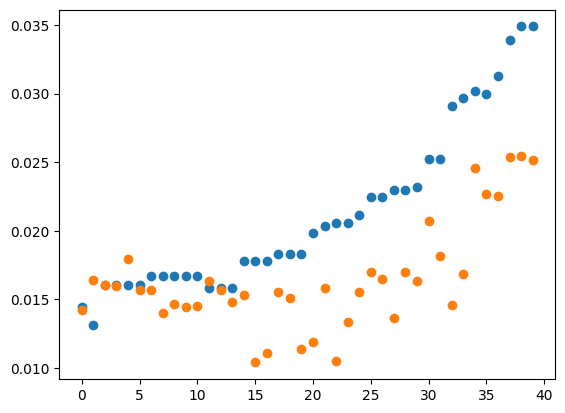

analytic


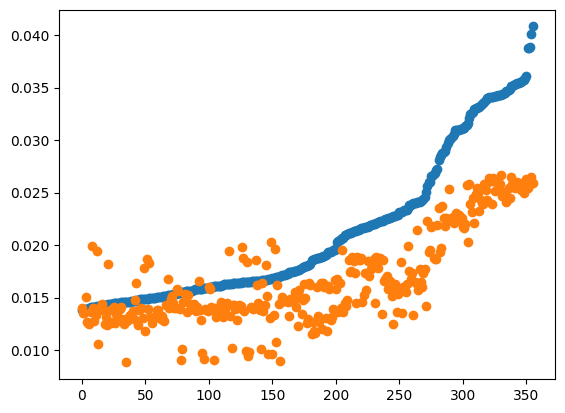

cnn output for cm and gen


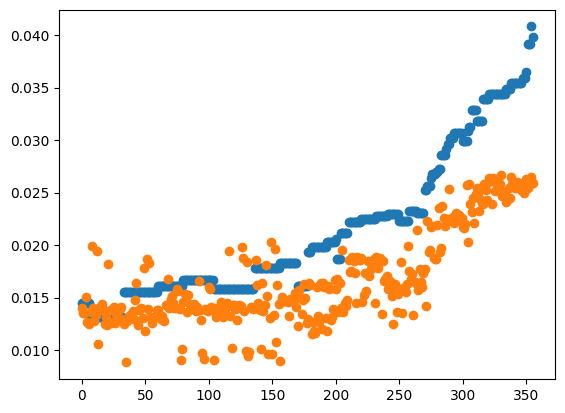

test perf


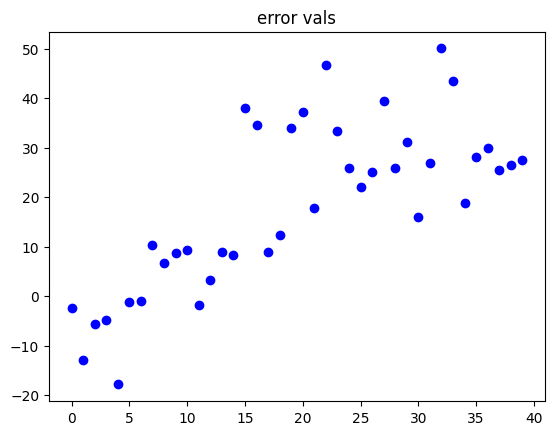

average percent error:  [20.7037]
within 50% of ground truth:  0.975
within 10% of ground truth:  0.325
within 5% of ground truth:  0.15
non analytic


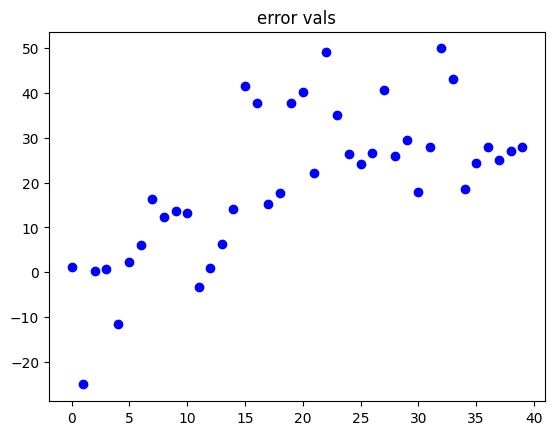

average percent error:  [22.165068]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.2
within 5% of ground truth:  0.15
test perf ALC


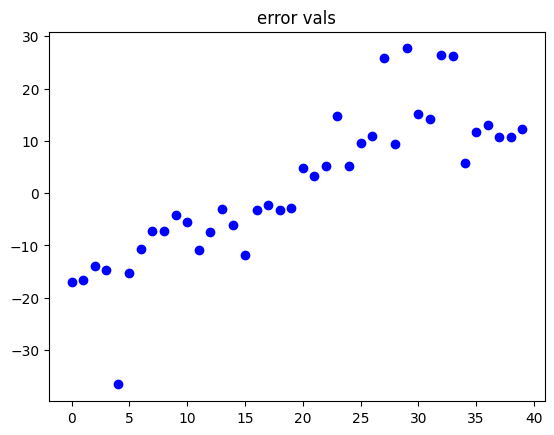

average percent error:  [11.573243]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.45
within 5% of ground truth:  0.2


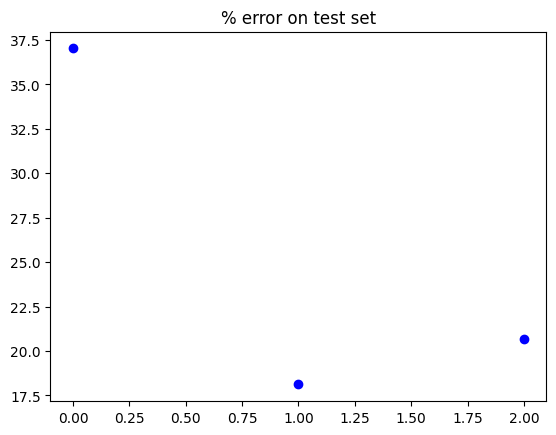

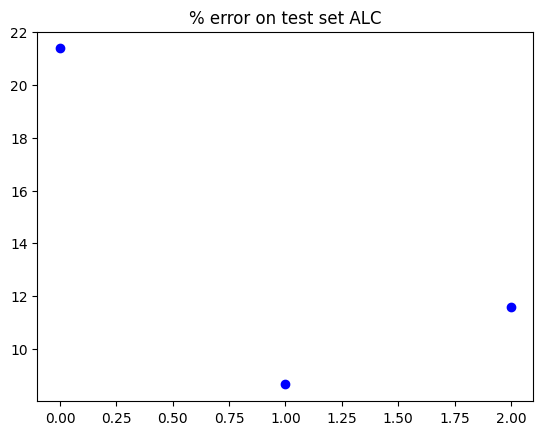

2/2 [==============================] - 0s 16ms/step


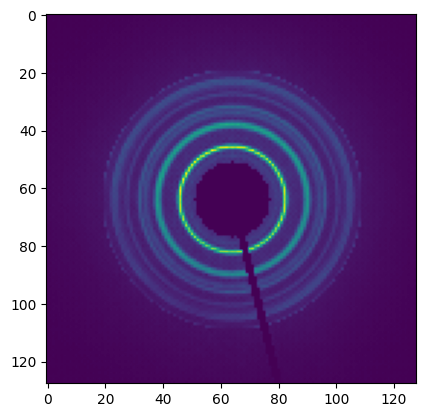

TRAIN PERFORMANCE: 


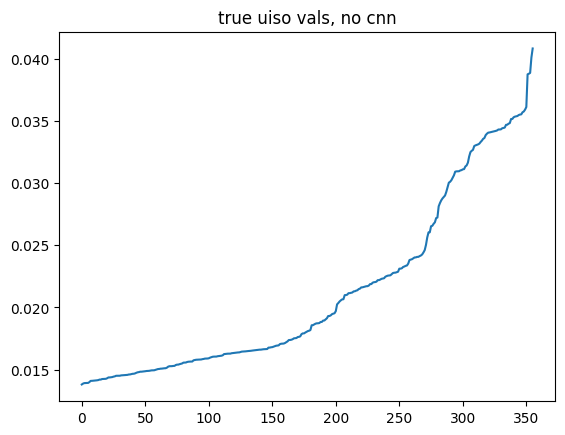

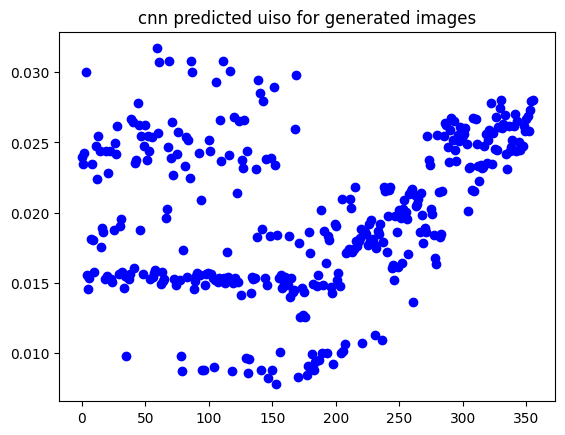

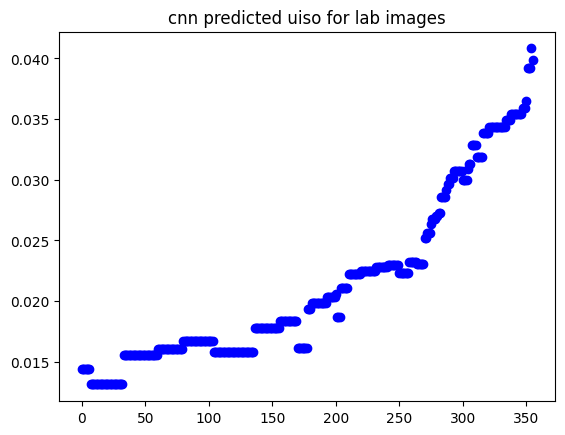

train perf


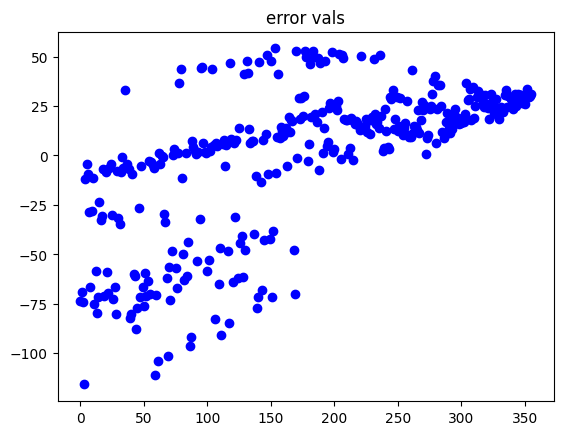

average percent error:  [29.369728]
within 50% of ground truth:  0.8146067415730337
within 10% of ground truth:  0.22191011235955055
within 5% of ground truth:  0.10955056179775281
non analytic


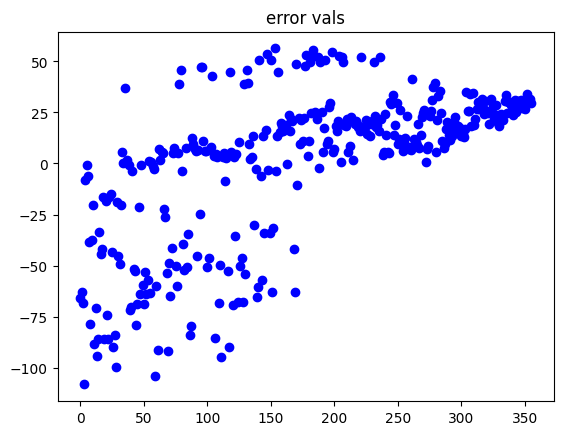

average percent error:  [29.414646]
within 50% of ground truth:  0.8033707865168539
within 10% of ground truth:  0.22191011235955055
within 5% of ground truth:  0.0898876404494382
train perf ALC


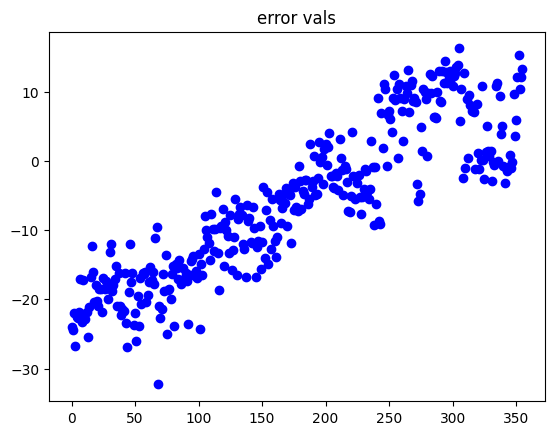

average percent error:  [10.462154]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.5168539325842697
within 5% of ground truth:  0.2696629213483146


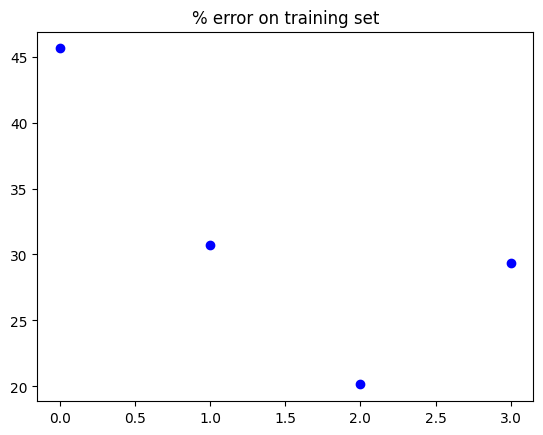

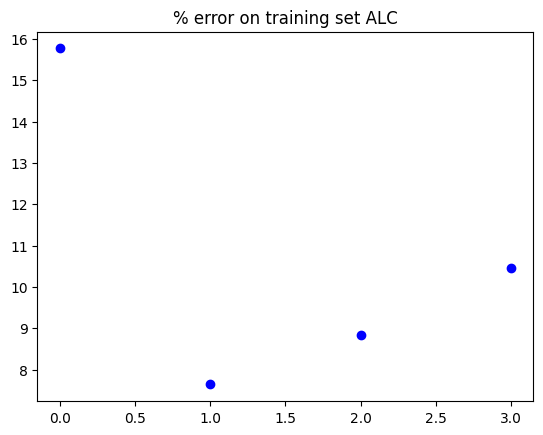

TEST PERFORMANCE: 


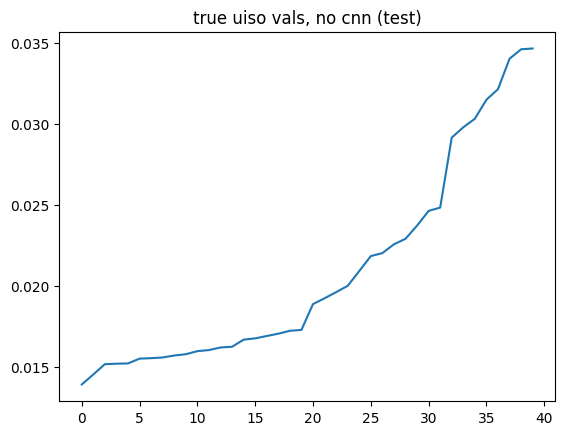

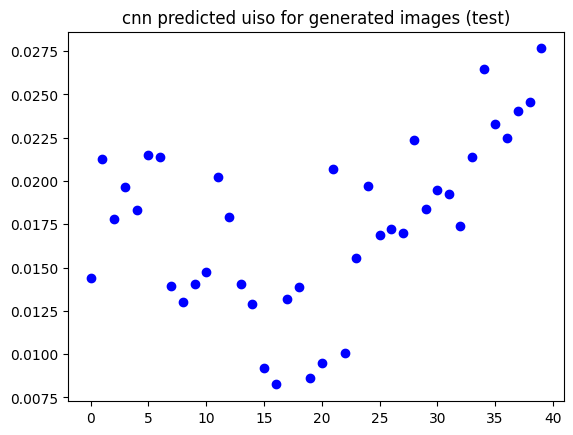

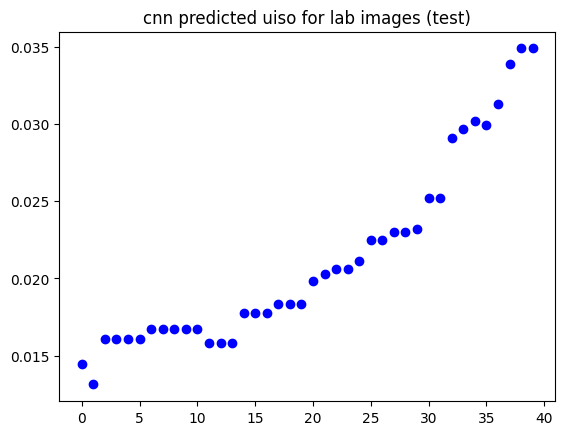

analytic


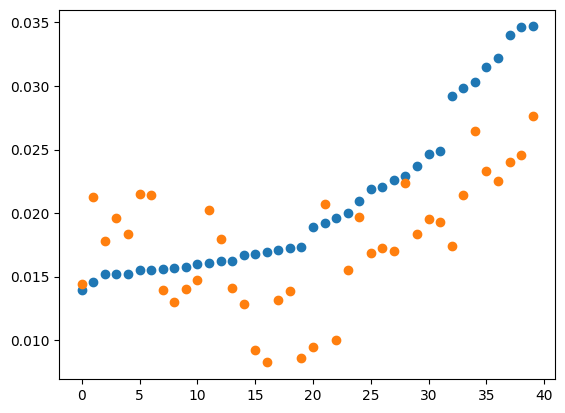

cnn output for cm and gen


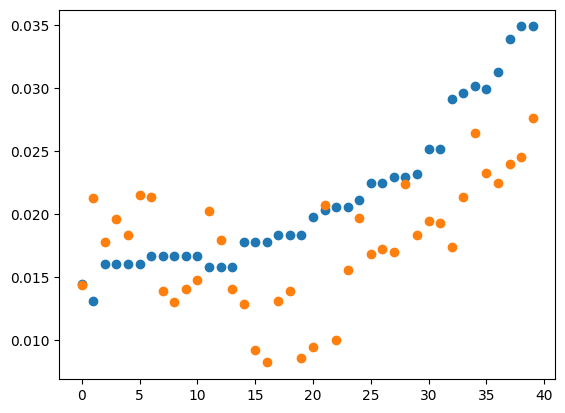

analytic


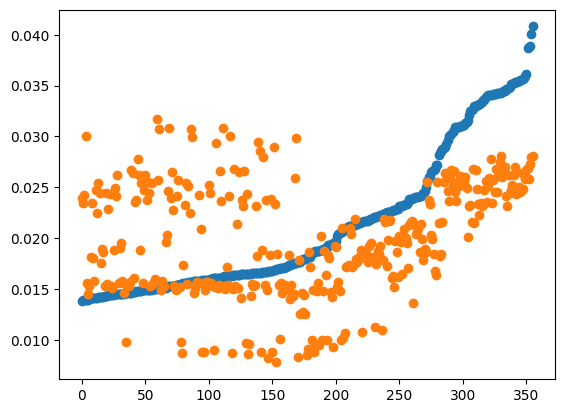

cnn output for cm and gen


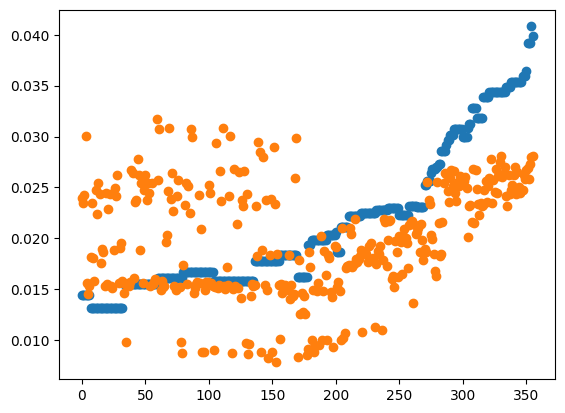

test perf


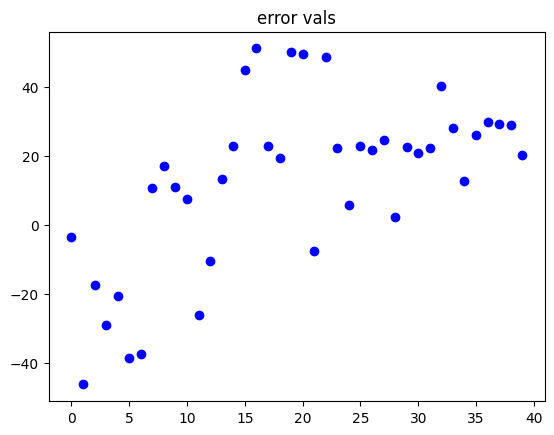

average percent error:  [24.736767]
within 50% of ground truth:  0.95
within 10% of ground truth:  0.125
within 5% of ground truth:  0.05
non analytic


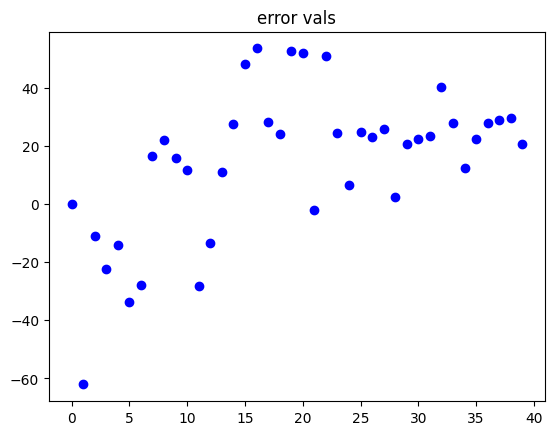

average percent error:  [25.378437]
within 50% of ground truth:  0.875
within 10% of ground truth:  0.1
within 5% of ground truth:  0.075
test perf ALC


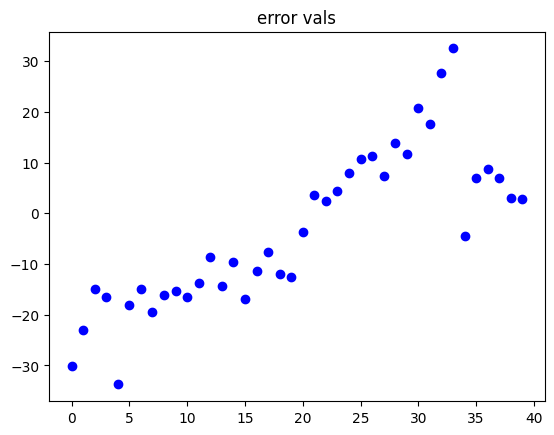

average percent error:  [13.36236]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.375
within 5% of ground truth:  0.175


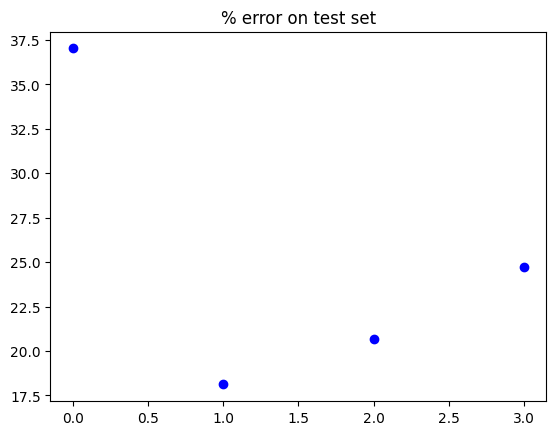

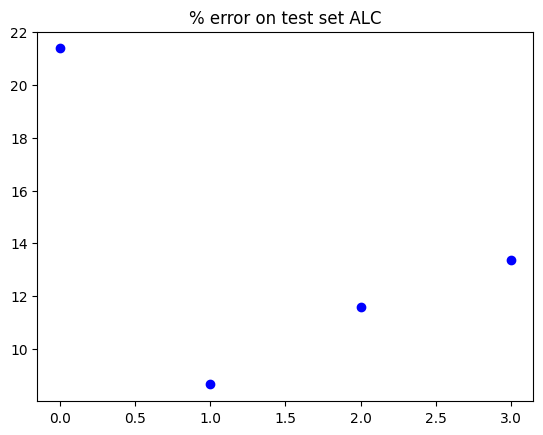

2/2 [==============================] - 0s 4ms/step


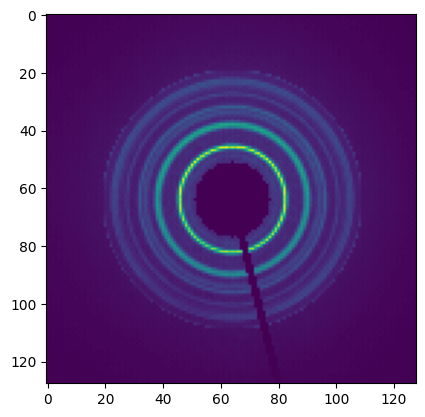

TRAIN PERFORMANCE: 


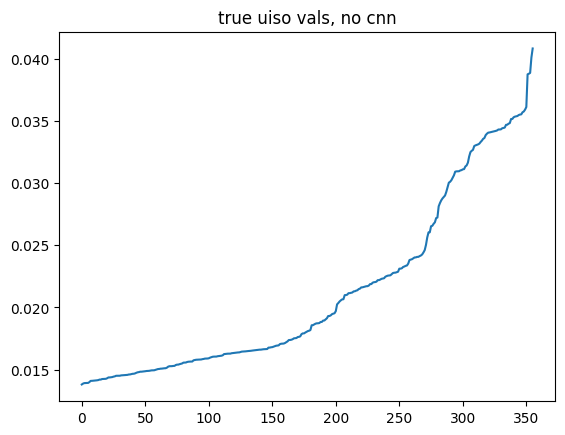

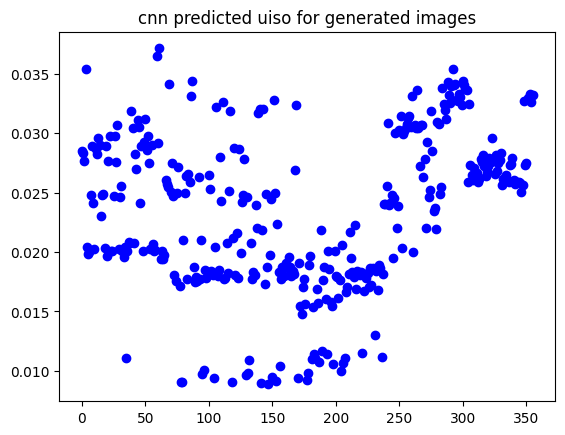

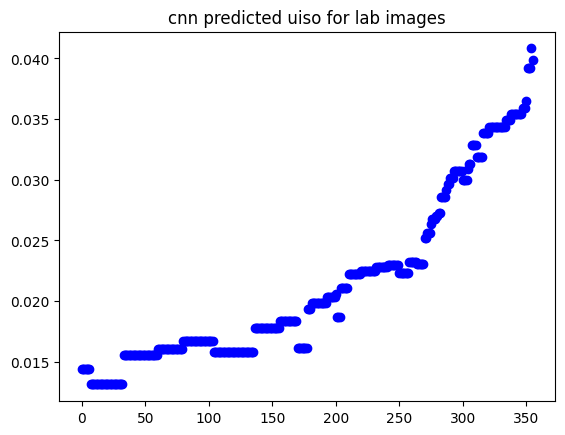

train perf


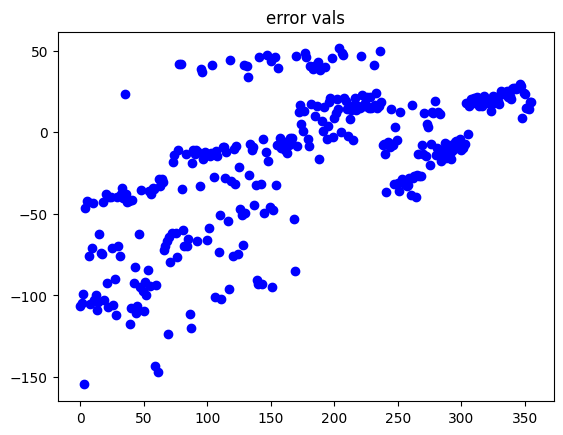

average percent error:  [35.458973]
within 50% of ground truth:  0.7893258426966292
within 10% of ground truth:  0.1601123595505618
within 5% of ground truth:  0.05337078651685393
non analytic


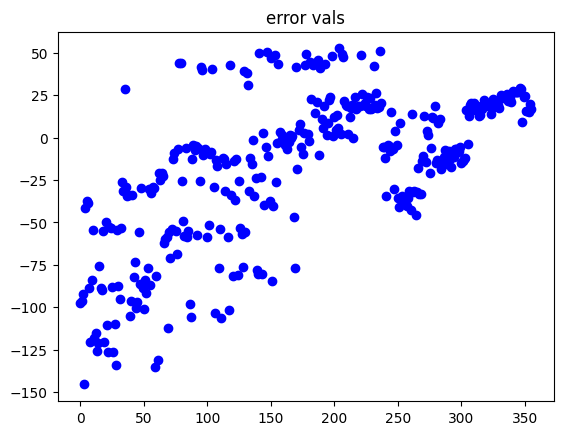

average percent error:  [35.291443]
within 50% of ground truth:  0.7640449438202247
within 10% of ground truth:  0.1797752808988764
within 5% of ground truth:  0.08707865168539326
train perf ALC


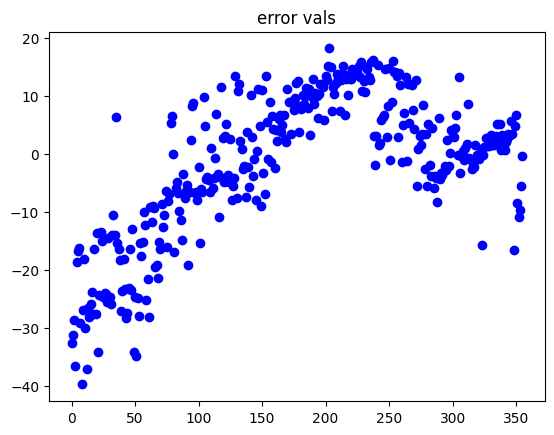

average percent error:  [9.908526]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.5786516853932584
within 5% of ground truth:  0.34269662921348315


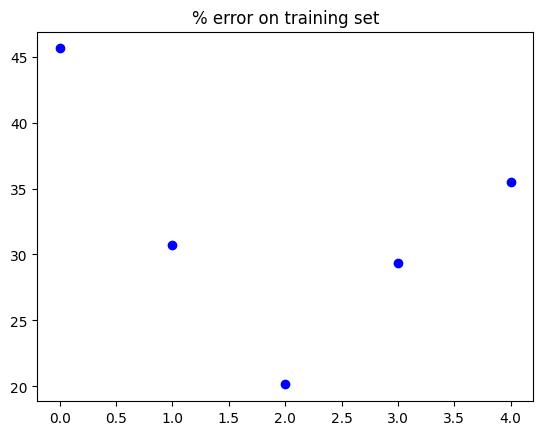

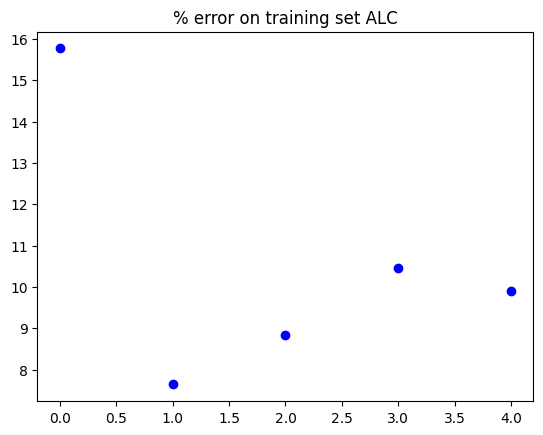

TEST PERFORMANCE: 


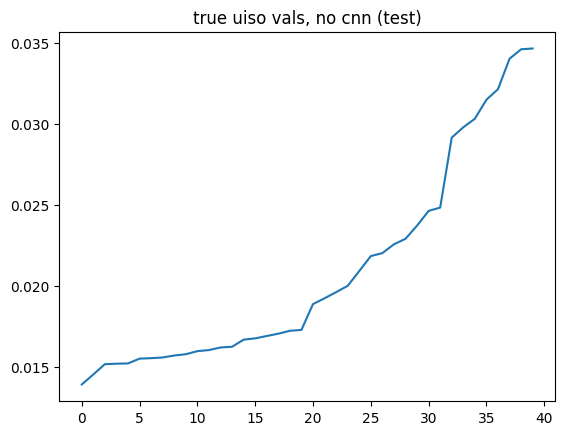

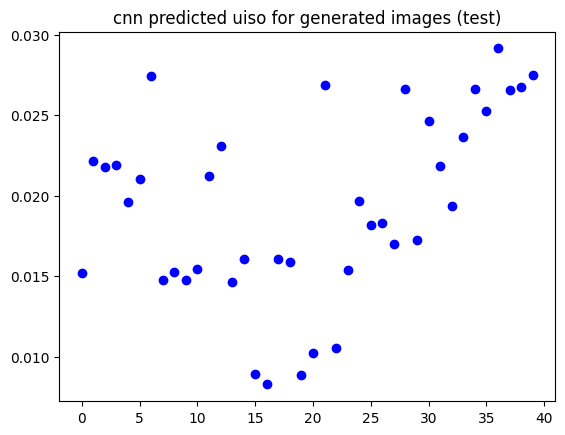

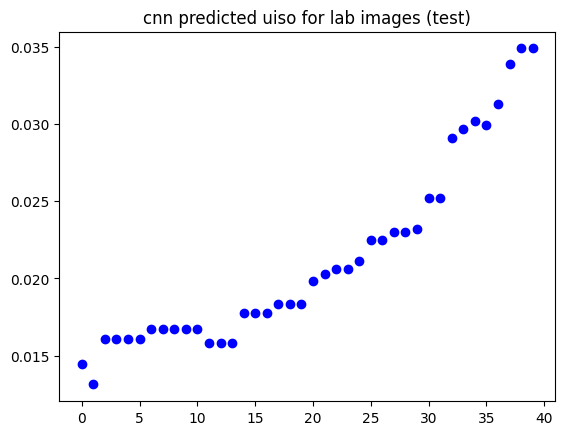

analytic


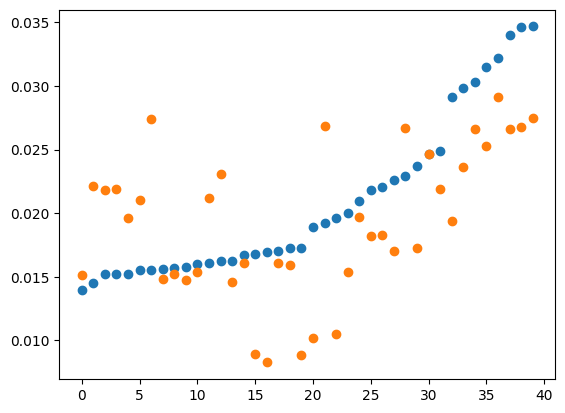

cnn output for cm and gen


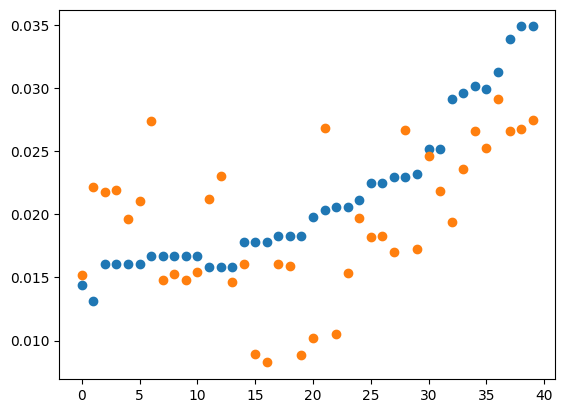

analytic


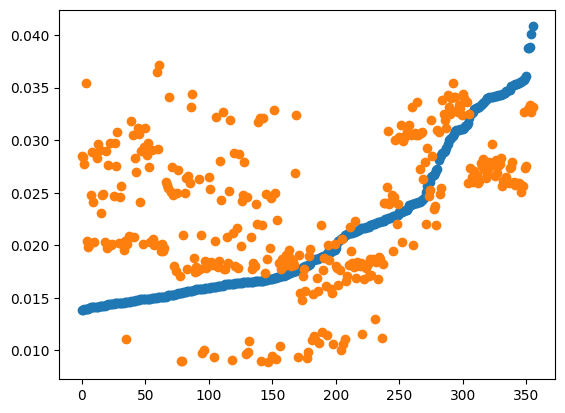

cnn output for cm and gen


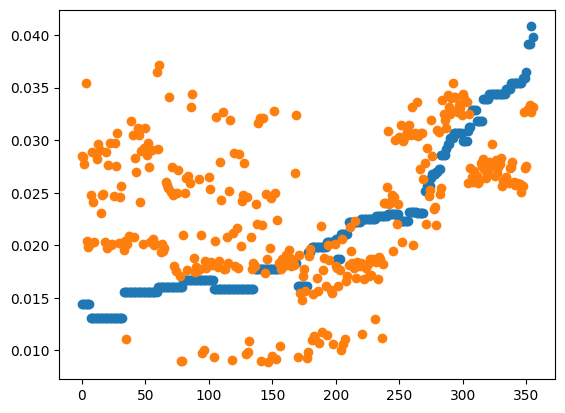

test perf


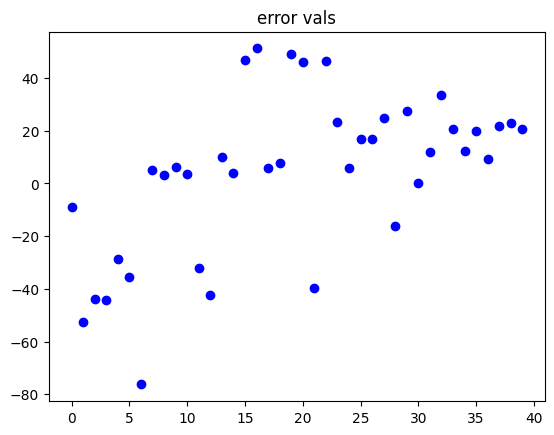

average percent error:  [24.83846]
within 50% of ground truth:  0.925
within 10% of ground truth:  0.275
within 5% of ground truth:  0.1
non analytic


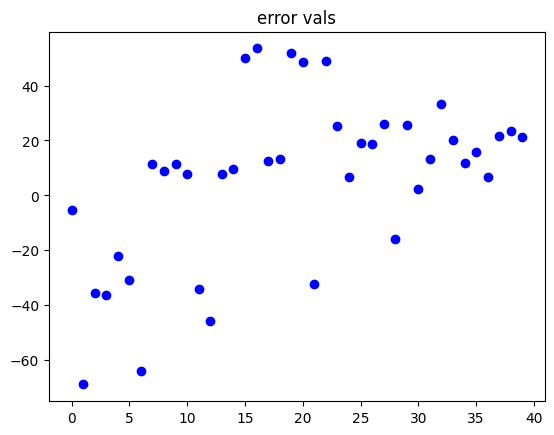

average percent error:  [25.438616]
within 50% of ground truth:  0.9
within 10% of ground truth:  0.2
within 5% of ground truth:  0.025
test perf ALC


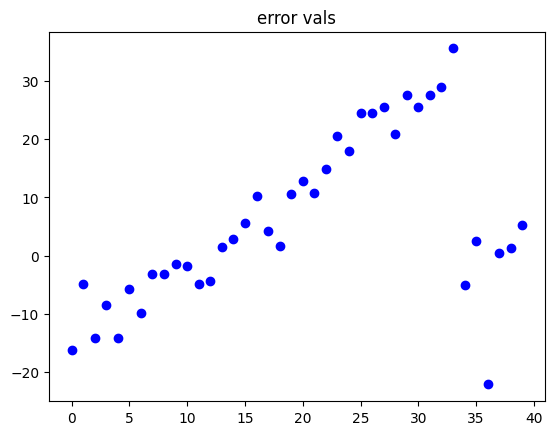

average percent error:  [12.094128]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.5
within 5% of ground truth:  0.375


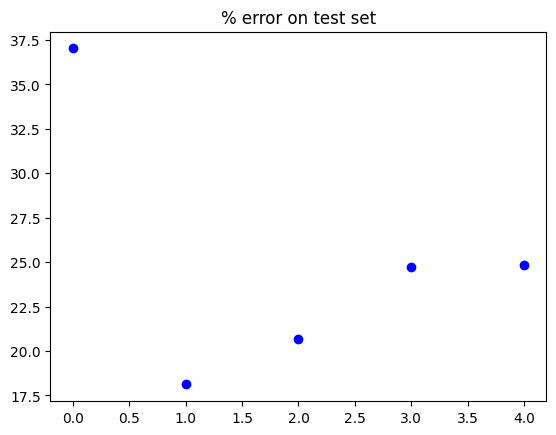

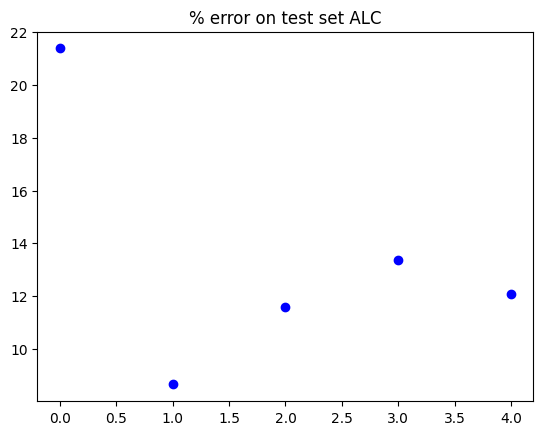

2/2 [==============================] - 0s 5ms/step


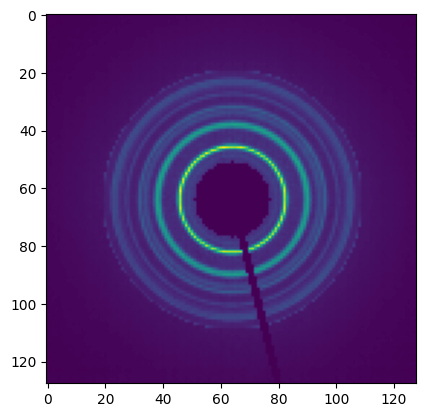

TRAIN PERFORMANCE: 


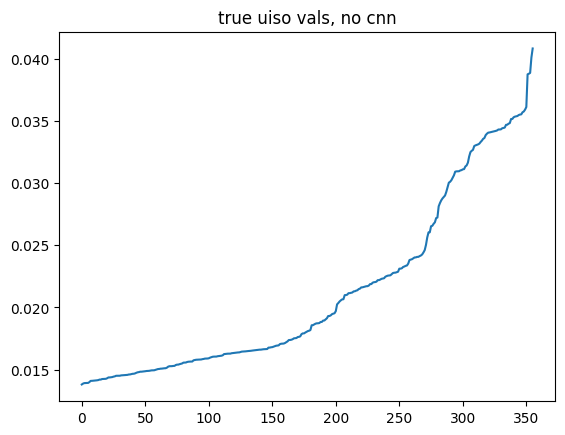

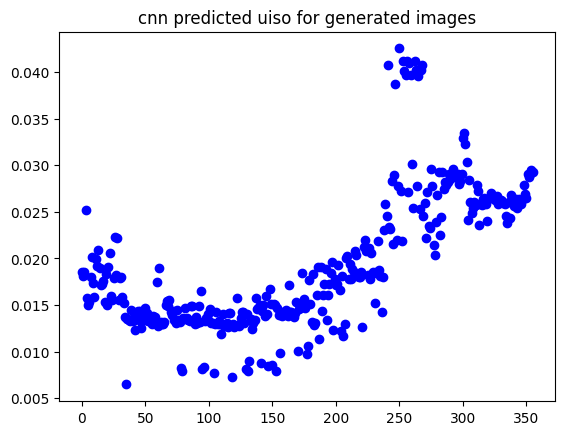

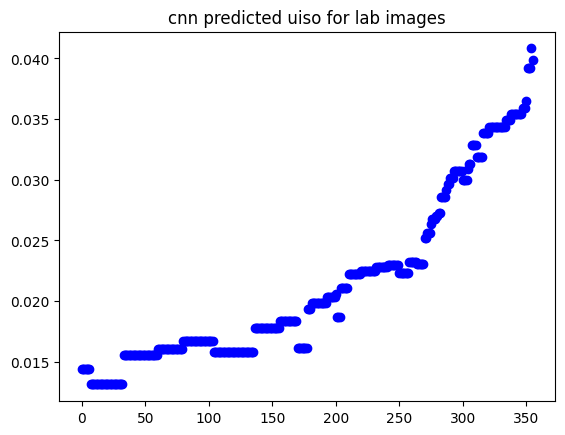

train perf


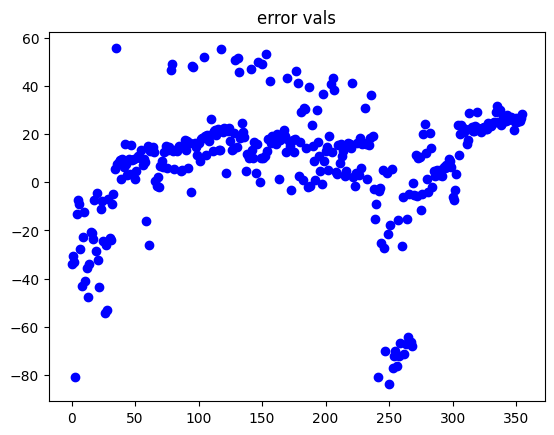

average percent error:  [19.828007]
within 50% of ground truth:  0.9353932584269663
within 10% of ground truth:  0.2949438202247191
within 5% of ground truth:  0.15168539325842698
non analytic


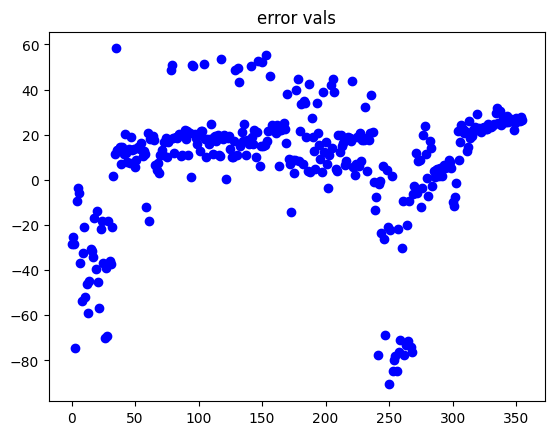

average percent error:  [22.10841]
within 50% of ground truth:  0.9129213483146067
within 10% of ground truth:  0.22191011235955055
within 5% of ground truth:  0.0898876404494382
train perf ALC


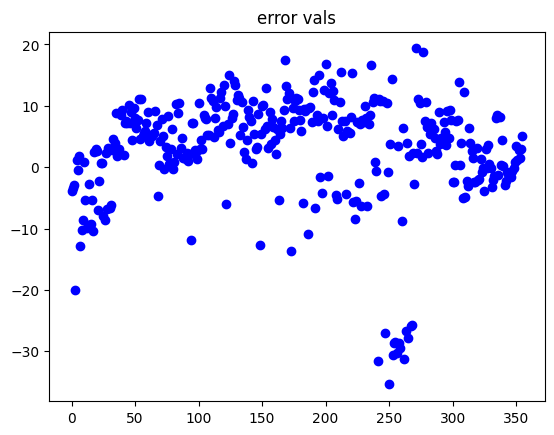

average percent error:  [7.2313824]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.7808988764044944
within 5% of ground truth:  0.38764044943820225


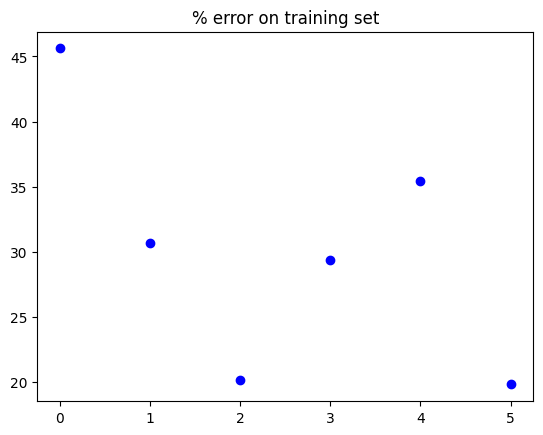

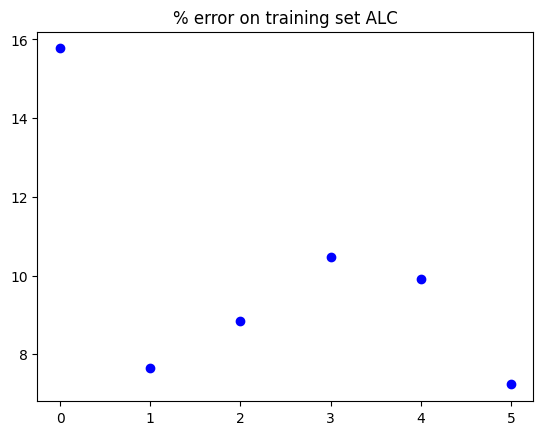

TEST PERFORMANCE: 


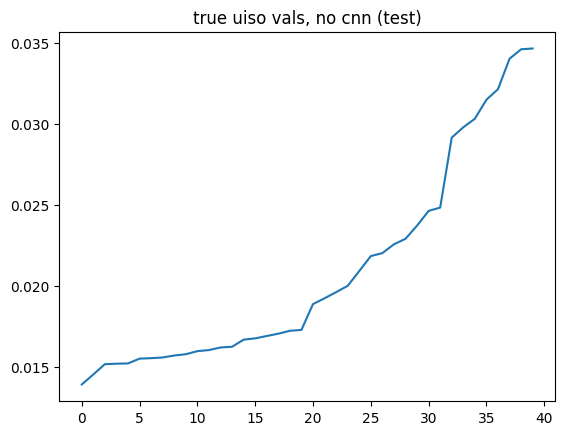

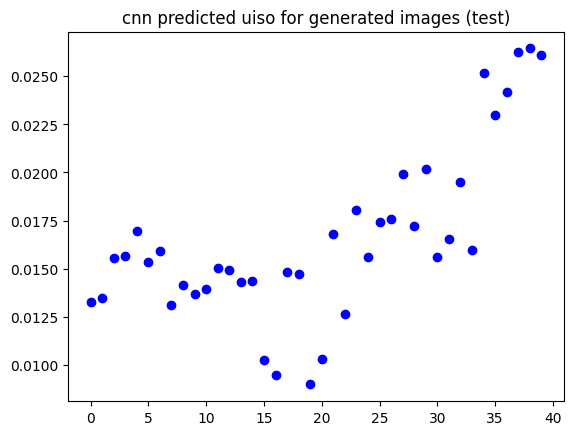

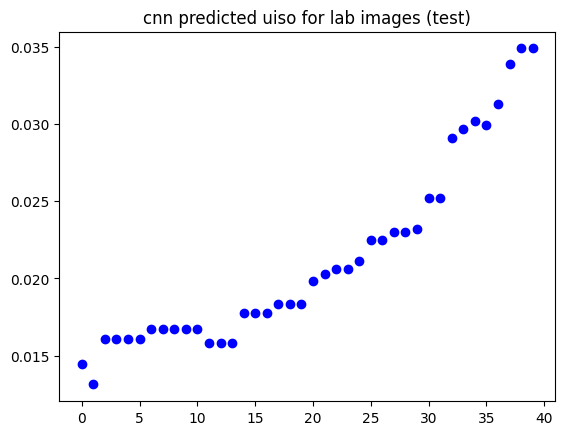

analytic


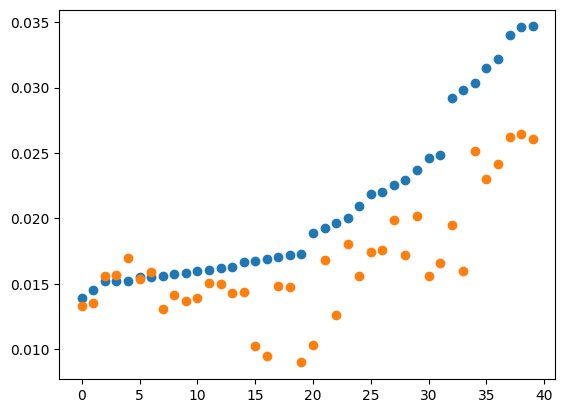

cnn output for cm and gen


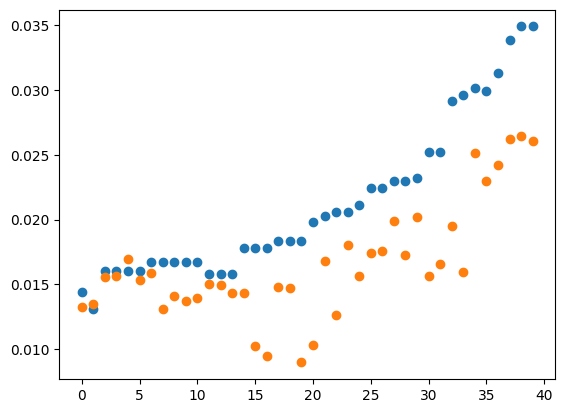

analytic


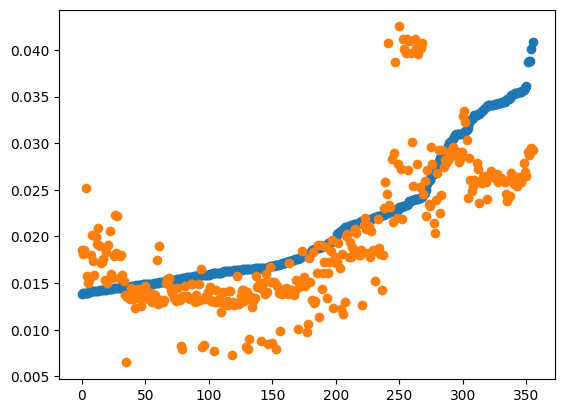

cnn output for cm and gen


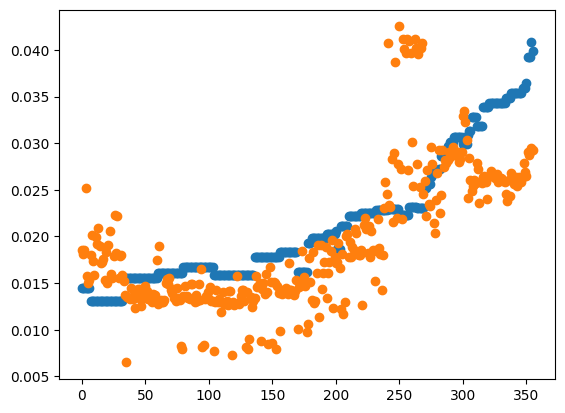

test perf


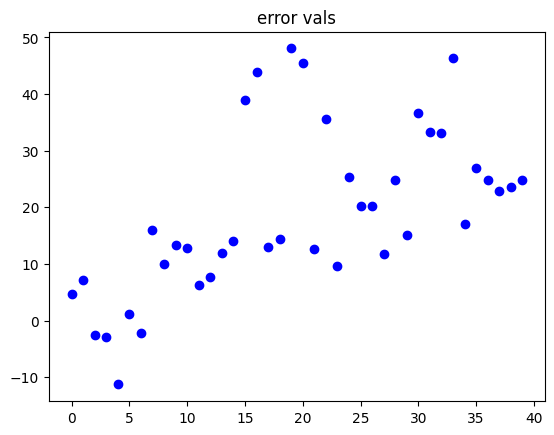

average percent error:  [19.833874]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.25
within 5% of ground truth:  0.125
non analytic


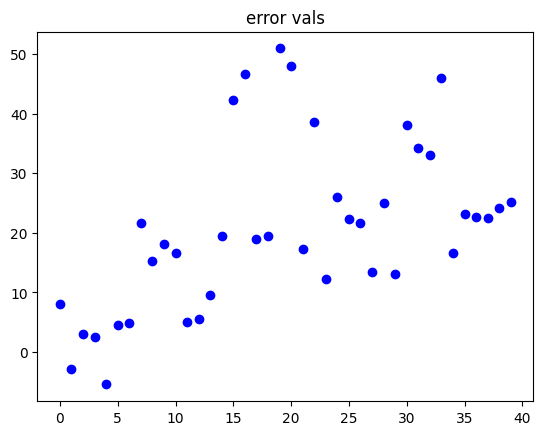

average percent error:  [21.102594]
within 50% of ground truth:  0.975
within 10% of ground truth:  0.25
within 5% of ground truth:  0.15
test perf ALC


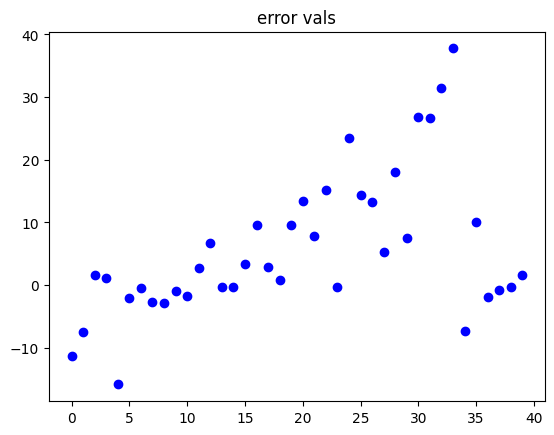

average percent error:  [8.691464]
within 50% of ground truth:  1.0
within 10% of ground truth:  0.675
within 5% of ground truth:  0.475


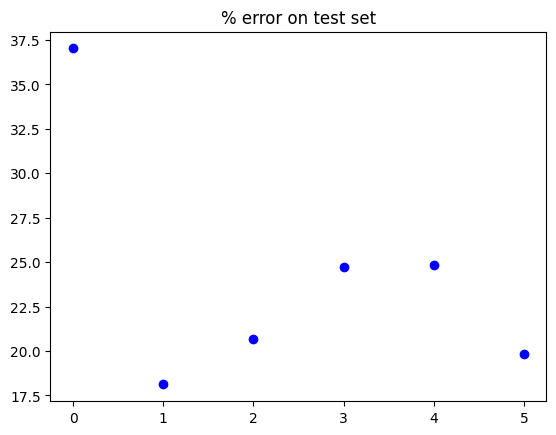

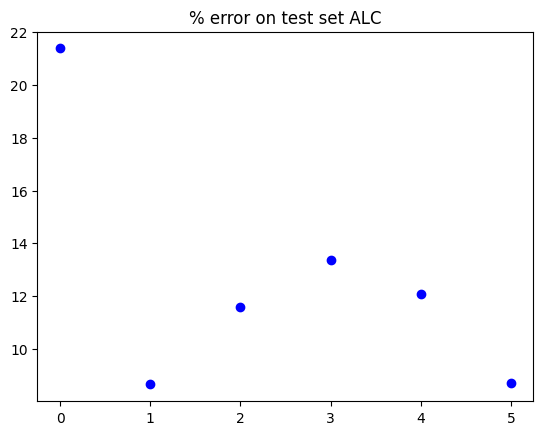

.

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
dict_errors = {}

CNN_parameters = [] #[100,100,100,100,100,100,100,100]

SP_parameters = [] #[[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1],[-20.0,-2.0,1.1]]#,[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1],[-50.0,-2.0,1.1]]


#we know [100] , [-20,-2,-1.1] works well
#[-15, -2.5, 1.1]
#check to see if there is a loss that can be used to detect degraded

num_ = 5
for CNN_param_iter in [120]:#80,90,100]:#[100,80,120]:
  for SSIM_param in [-15]:#[-12.5,-15,-20]:#,-25,-30]:
    for PSNR_param in [-2.5]:#[-2,-2.5]:#[-1,-1.5,-2]:
      CNN_parameters = []
      SP_parameters = []

      for experiment in range(1):
        num_+=1

        CNN_param = CNN_param_iter#CNN_parameters[experiment]
        #SP_params = SP_parameters[experiment]
        #SSIM_FACTOR = SSIM_param#SP_params[0]
        #PSNR_FACTOR = PSNR_param#SP_params[1]
        #SP_LOSS_FACTOR = 1.1#SP_params[2]
        CNN_loss_coeff_val = CNN_param

        #print("SSIM: ", SSIM_param)
        #print("PSNR: ", PSNR_param)
        print("CNN: ",CNN_param_iter)
        print("experiment: ", experiment)

        CNN_parameters.append(CNN_param_iter)
        SP_parameters.append([SSIM_param,PSNR_param,SP_LOSS_FACTOR])

        #generator = Generator()
        #discriminator = Discriminator()
        #generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        #discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        @tf.function
        def train_step(input_image, target, uiso_val, step,use_CNN,CNN_loss_coeff):
          with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator([input_image, target], training=True)


            #disc_real_output = discriminator([target,target], training=True)


            disc_generated_output = discriminator([input_image, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss,gen_CNN_LOSS,SP_Loss = generator_loss(disc_generated_output, gen_output, target,uiso_val,use_CNN,CNN_loss_coeff)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

          generator_gradients = gen_tape.gradient(gen_total_loss,
                                                  generator.trainable_variables)
          discriminator_gradients = disc_tape.gradient(disc_loss,
                                                      discriminator.trainable_variables)

          generator_optimizer.apply_gradients(zip(generator_gradients,
                                                  generator.trainable_variables))
          discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                      discriminator.trainable_variables))

          with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
            tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

          return (gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,gen_CNN_LOSS,SP_Loss)


        def fit(train_ds, test_ds, steps,use_CNN,CNN_loss_coeff):
          gen_total_loss_list,gen_gan_loss_list, gen_l1_loss_list,disc_loss_list,CNN_uiso_loss_list, SP_Loss_list = [],[],[],[],[],[]

          example_input, example_target,example_uiso_val = next(iter(test_ds.take(1)))
          #start = time.time()
          step_ctr =0
          for step, (input_image, target,uiso_val) in train_ds.repeat().take(steps).enumerate():
            step_ctr+=1
            #if (step) % 1000 == 0:
              #display.clear_output(wait=True)
              #generate_images(generator, example_input, example_target,num=1)
            #if (step+1) % 1000 == 0:
              #display.clear_output(wait=True)
              #start = time.time()

              #generate_images(generator, example_input, example_target)
              #print(f"Step: {step//1000}k")
            (gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,CNN_uiso_loss,SP_Loss) = train_step(input_image, target,uiso_val , step,use_CNN,CNN_loss_coeff)
            gen_total_loss_list.append(gen_total_loss.numpy())
            gen_gan_loss_list.append(gen_gan_loss.numpy())
            gen_l1_loss_list.append(gen_l1_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())
            CNN_uiso_loss_list.append(CNN_uiso_loss.numpy())
            SP_Loss_list.append(SP_Loss.numpy())
            """
            print("total gen loss: ", gen_total_loss)
            print("gen gan loss: ", gen_gan_loss)
            print("gen l1 loss: ", gen_l1_loss)
            print("CNN uiso loss: ", CNN_uiso_loss)
            print("SP Loss: ",SP_Loss)
            """
            #h+=1
            # Training step
            #if (step+1) % 10 == 0:
            #  print('.', end='', flush=True)


            # Save (checkpoint) the model every 5k steps
            if (step + 1) % 10000 == 0:
              print("saved")
              checkpoint.save(file_prefix=checkpoint_prefix)


          #print(gen_total_loss_list)
          return sum(gen_total_loss_list)/step_ctr,sum(gen_gan_loss_list)/step_ctr, sum(gen_l1_loss_list)/step_ctr,sum(disc_loss_list)/step_ctr,sum(CNN_uiso_loss_list)/step_ctr, sum(SP_Loss_list)/step_ctr

        def gen_img_for_Training(model, test_input,uiso_labels,example_uiso):
          prediction = model(test_input, training=True)

          output_arr = []
          for idx in range(0,np.shape(prediction)[0]):
            #print(uiso_labels[idx])
            output_arr.append([uiso_labels[idx],prediction[idx],example_uiso[idx]])
          return output_arr

        def create_gen_set(generator,uiso_dataset,num=3):
          list_gen_output = []
          if num == 3:
            for example_input, example_target, example_uiso in uiso_dataset.as_numpy_iterator():#uiso_dataset.take(3):
              #generate_images(generator,batch)
              #print(example_uiso.shape)
              #i+=1
              list_gen_output += gen_img_for_Training(generator, example_input,example_target,example_uiso)
              #break
            return list_gen_output
          else:
            for example_input, example_uiso in uiso_dataset.as_numpy_iterator():#uiso_dataset.take(3):
              #generate_images(generator,batch)
              #print(example_uiso.shape)
              #i+=1
              list_gen_output += gen_img_for_Training(generator, example_input,example_uiso)
              #break
            return list_gen_output


        train_stats = []
        test_stats = []

        train_stats_ALC = []
        test_stats_ALC = []


        avg_train_error = []
        avg_test_error = []

        avg_train_error_ALC = []
        avg_test_error_ALC = []


        num_iter = 21#15#30#30#45#30#40#50#80
        print("starting")
        gen_total_loss_list,gen_gan_loss_list, gen_l1_loss_list,disc_loss_list,CNN_uiso_loss_list, SP_Loss_list = [],[],[],[],[],[]
        start_with_cnn = True
        iter_boost_cnn = 5*60

        train_dataset_GAN_2,test_dataset_GAN_2 = gen_shuffled_data()


        #CNN_loss_coeff_val = 500
        for idx_ in range(num_iter):
          if idx_ == iter_boost_cnn:
              CNN_loss_coeff_val = CNN_loss_coeff_val*2
          if (idx_) % 10 == 0 or num_iter == 1:
            print("")
            print("epoch: ", idx_+1)

          print('.', end='', flush=True)
          if idx_ < 25 and not start_with_cnn:
            #print("hi")'
            gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,CNN_uiso_loss,SP_Loss = fit(train_dataset_GAN_2, test_dataset_GAN_2, steps=367,use_CNN=False,CNN_loss_coeff=CNN_loss_coeff_val)#10000#60000)
          else:
            #print("hi")
            gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,CNN_uiso_loss,SP_Loss = fit(train_dataset_GAN_2, test_dataset_GAN_2, steps=367,use_CNN=True,CNN_loss_coeff=CNN_loss_coeff_val)#10000#60000)


          gen_total_loss_list.append(gen_total_loss)
          gen_gan_loss_list.append(gen_gan_loss)
          gen_l1_loss_list.append(gen_l1_loss)
          disc_loss_list.append(disc_loss)
          CNN_uiso_loss_list.append(CNN_uiso_loss)
          SP_Loss_list.append(SP_Loss)

          lab_gen = create_gen_set(generator,train_dataset_GAN_2,num=3)

          cm_imgs = []
          lab_imgs_gen = []
          for idx in range(len(lab_gen)):
            lab_imgs_gen.append(lab_gen[idx][1])
            cm_imgs.append(lab_gen[idx][0])
          lab_imgs_gen_arr = np.array(lab_imgs_gen)
          cm_imgs_arr = np.array(cm_imgs)

          pred_gen = model.predict(lab_imgs_gen_arr)
          pred_cm = model.predict(cm_imgs_arr)

          pred_gen_ALC = cnn_model.predict(lab_imgs_gen_arr)
          pred_cm_ALC = cnn_model.predict(cm_imgs_arr)


          #TEST performance
          lab_gen_test = create_gen_set(generator,test_dataset_GAN_2,num=3)
          cm_imgs_test = []
          lab_imgs_gen_test = []

          for idx in range(len(lab_gen_test)):
            lab_imgs_gen_test.append(lab_gen_test[idx][1])
            cm_imgs_test.append(lab_gen_test[idx][0])

          lab_imgs_gen_arr_test = np.array(lab_imgs_gen_test)
          cm_imgs_arr_test = np.array(cm_imgs_test)

          pred_gen_test = model.predict(lab_imgs_gen_arr_test)
          pred_cm_test = model.predict(cm_imgs_arr_test)

          pred_gen_ALC_test = cnn_model.predict(lab_imgs_gen_arr_test)
          pred_cm_ALC_test = cnn_model.predict(cm_imgs_arr_test)

          if True:#(idx_+1) % 3 == 0 or num_iter == 1:
            plt.imshow(lab_imgs_gen_arr[0,:,:,0])
            plt.show()
            print("TRAIN PERFORMANCE: ")
            plt.plot(labels_train)
            plt.title("true uiso vals, no cnn")
            plt.show()
            scatter_plot(pred_gen,title="cnn predicted uiso for generated images")
            scatter_plot(pred_cm,title="cnn predicted uiso for lab images")

            print("train perf")
            train_perf = error_calcs(labels_train,pred_gen,verbose=True,return_avg=True)
            print("non analytic")
            train_perf_ = error_calcs(pred_cm,pred_gen,verbose=True,return_avg=True)


            print("train perf ALC")
            train_perf_ALC = error_calcs(labels_train,pred_gen_ALC,verbose=True,return_avg=True)

            train_stats.append(train_perf[0])
            train_stats_ALC.append(train_perf_ALC[0])


            avg_train_error_ALC.append(train_perf_ALC[1][0])
            avg_train_error.append(train_perf[1][0])

            scatter_plot(avg_train_error,title="% error on training set")
            scatter_plot(avg_train_error_ALC,title="% error on training set ALC")

            print("TEST PERFORMANCE: ")
            plt.plot(labels_test)
            plt.title("true uiso vals, no cnn (test)")
            plt.show()
            scatter_plot(pred_gen_test,title="cnn predicted uiso for generated images (test)")
            scatter_plot(pred_cm_test,title="cnn predicted uiso for lab images (test)")


            x_test = list(range(len(pred_gen_test)))

            print("analytic")
            plt.scatter(x_test,labels_test)
            plt.scatter(x_test,pred_gen_test)
            plt.show()
            print("cnn output for cm and gen")
            plt.scatter(x_test,pred_cm_test)
            plt.scatter(x_test,pred_gen_test)
            plt.show()

            x_train = list(range(len(pred_gen)))

            print("analytic")
            plt.scatter(x_train,labels_train)
            plt.scatter(x_train,pred_gen)
            plt.show()
            print("cnn output for cm and gen")
            plt.scatter(x_train,pred_cm)
            plt.scatter(x_train,pred_gen)
            plt.show()



            print("test perf")
            test_perf = error_calcs(labels_test,pred_gen_test,verbose=True,return_avg=True)
            print("non analytic")
            train_perf_ = error_calcs(pred_cm_test,pred_gen_test,verbose=True,return_avg=True)
            print("test perf ALC")
            test_perf_ALC = error_calcs(labels_test,pred_gen_ALC_test,verbose=True,return_avg=True)

            test_stats.append(test_perf[0])
            test_stats_ALC.append(test_perf_ALC[0])

            avg_test_error.append(test_perf[1][0])
            avg_test_error_ALC.append(test_perf_ALC[1][0])

            scatter_plot(avg_test_error,title="% error on test set")
            scatter_plot(avg_test_error_ALC,title="% error on test set ALC")


            #test_stats.append(error_calcs(pred_cm_test,pred_gen_test,verbose=True))
            #checkpoint.save(file_prefix=checkpoint_prefix)


          else:
            train_perf = error_calcs(labels_train,pred_gen,verbose=False,return_avg=True)
            train_perf_ALC = error_calcs(labels_train,pred_gen_ALC,verbose=False,return_avg=True)

            test_perf = error_calcs(labels_test,pred_gen_test,verbose=False,return_avg=True)
            test_perf_ALC = error_calcs(labels_test,pred_gen_ALC_test,verbose=False,return_avg=True)

            train_stats.append(train_perf[0])
            test_stats.append(test_perf[0])

            train_stats_ALC.append(train_perf_ALC[0])
            test_stats_ALC.append(test_perf_ALC[0])


            avg_train_error.append(train_perf[1][0])
            avg_test_error.append(test_perf[1][0])

            avg_train_error_ALC.append(train_perf_ALC[1][0])
            avg_test_error_ALC.append(test_perf_ALC[1][0])

            if (idx_+1) % 10 == 0:
              print(" ")
              print("train error: ",train_perf[1][0])
              print("test error: ",test_perf[1][0])


        plt.imshow(lab_imgs_gen_arr[0,:,:,0])
        plt.show()
        #scatter_plot(avg_train_error,title="% error on training set")

        under_10,under_5 = zip(*train_stats)
        scatter_plot(under_10,title="num within 10% error")
        scatter_plot(under_5,title="num within 5% error")

        under_10,under_5 = zip(*train_stats_ALC)
        scatter_plot(under_10,title="num within 10% error ALC")
        scatter_plot(under_5,title="num within 5% error ALC")




        #plt.plot(avg_train_error)
        #plt.show()

        fig, ax = plt.subplots()
        ax.plot(avg_train_error,color = "red",label="Training Error")
        ax.plot(avg_test_error, color = "blue",label="Test Error")
        ax.set_xlabel("Number of Epochs", fontsize= 10)
        ax.set_ylabel("Percent Error",fontsize= 10)
        ax.legend(prop={'size': 12})
        plt.show()
        title = "graph_without_title_" + str(num_) +".eps"
        fig.savefig(title,format='eps',dpi=200)



        scatter_plot(avg_test_error,title="% error on test set")
        print("")
        #print("lowest test error: ",min(avg_test_error))
        #print("average test error (first 5 epochs skipped): ", np.average(avg_test_error[4:]))

        #print("standard dev in test error (first 5 epochs skipped): ", np.std(avg_test_error[4:]))
        under_10,under_5 = zip(*test_stats)
        scatter_plot(under_10,title="num within 10% error (test)")
        scatter_plot(under_5,title="num within 5% error (test)")

        under_10,under_5 = zip(*test_stats_ALC)
        scatter_plot(under_10,title="num within 10% error (test) ALC")
        scatter_plot(under_5,title="num within 5% error (test) ALC")

        #scatter_plot(gen_total_loss_list,title="Total Generator Loss")
        #scatter_plot(gen_l1_loss_list,title="L1 Gen Loss")
        #scatter_plot(SP_Loss_list,title="SP Loss")
        #scatter_plot(CNN_uiso_loss_list,title="CNN Disc Loss")
        dict_errors[experiment] = (avg_train_error_ALC,avg_test_error_ALC)
        print("train:")
        print(avg_train_error)
        print("test:")
        print(avg_test_error)
        print("train alc:")
        print(avg_train_error_ALC)
        print("test alc:")
        print(avg_test_error_ALC)

      print("-----")

      overall_avg_test = []
      for experiment in dict_errors.keys():
        print("experiment: ",experiment)
        print("CNN param: ", str(CNN_parameters[experiment]))
        print("SP params: ", str(SP_parameters[experiment]))

        err_lists_tuple = dict_errors[experiment]

        train_list = err_lists_tuple[0]
        test_list = err_lists_tuple[1]

        sub_5_ctr = 0
        min_train = min(train_list)
        epoch_min_train = train_list.index(min_train)

        for i in range(len(train_list)):
          val = train_list[i]
          if val < 5:
            sub_5_ctr+=1
          if sub_5_ctr == 4:
            print("choosing fourth sub 5 val")
            epoch_min_train =  i
            break

        test_at_min_train = test_list[epoch_min_train]

        min_test = min(test_list)
        epoch_min_test = test_list.index(min_test)
        train_at_min_test = train_list[epoch_min_test]

        print("min train error is: ",min_train, " at epoch: ",epoch_min_train," with test error of: ",test_at_min_train)
        print("min test error is: ",min_test, " at epoch: ", epoch_min_test, " with train error of: ",train_at_min_test)
        avg_test_error = sum(test_list)/len(test_list)
        overall_avg_test.append(avg_test_error)
        print("average test error is: ", avg_test_error)
        scatter_plot(train_list,title="error on training set")
        scatter_plot(test_list,title="error on test set")

      scatter_plot(overall_avg_test,title="plot of average % error on test set over experiments")

#1st 4 have avg min of about 8, decent img
#next 4 have about 8 as well, bad img
#next 4 have 5% but bad img
#same for last

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)